# **ICU Database Machine Learning Pipeline**

## **By:** Mariah Noelle Cornelio

**Research Question:** Can we predict ICU patient poor outcomes (death or readmission) using demographic, clinical, and physiological data from the dataset, and how does imbalance affect model performance? 

**Pipeline Overview:** 

1. Load in data and dependencies
2. EDA
3. Reference Baseline
4. Data Preprocessing and Cleaning
5. Reference Baseline for Standardized Data and Unstandardized Data
6. Feature Engineering
7. Reference Baseline
8. Handling Class Imbalance Overview (Core Research Component)
9. Training Base Models for Unbalanced Dataset
10. Training Base Models for Balanced Dataset
11. Building Stacked Model for Unbalanced Dataset
12. Building Stacked Model for Balanced Dataset
13. Testing Unbalanced and Balanced Stacked Models 
14. Final Evaluation and Comparison of Stacked Models (feature importance)
15. ICU Simulation
16. Single Model Overview
17. Training and Testing Individual Models for Unbalanced Dataset
18. Training and Testing Individual Models for Balanced Dataset
19. Final Evaluation and Comparison of Individual Models (feature importance)
20. ICU Simulation
21. Implication and Insights

**Goal and Notes:** So from roughly looking at the data, there is a huge class imbalance. This is fine, it reflects real world situations where not a lot of people are admitted to the ICU on a large scale. I believe only ~5% are admitted to the ICU. This class imbalance needs to be addressed later on during training. As of now, the target variable is "bad_outcome" which includes death AND readmission back into the ICU. So this is a binary classification problem. I'd like the final model to reflect this real world data, so maybe undersampling of the majority class can be done? **(Beware of overfitting)**. At the same time, I want to keep it realistic and since this is medical data, I need to stay true and keep the integrity of the data so imputing might serve as an issue. **(Could try KNN imputation)**. Primary metric used will be recall > F1 > ROC-AUC > Precision-Recall AUC. Accuracy is not a good metric for this study. 

**What sets my pipeline apart from Darlene and Alain:** My core research component is testing no balance (real distribution) and balanced class weight.

## **Part 1: Load in data and dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stats + VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Preprocessing + Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    recall_score, precision_score, f1_score)

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# Feature importance
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv("mergeICU_db.csv")

## **Part 2: EDA**

**First look at data**

In [3]:
df.head(5)

,patientunitstayid,gender,age,ethnicity,hospitalid,unittype,admissionheight,admissionweight,dischargeweight,unitadmitsource,...,ventday1,nettotal,sao2_mean,sao2_min,heartrate_mean,heartrate_max,heartrate_std,respiration_mean,respiration_max,bad_outcome
0,141764,Female,87,Caucasian,59,Med-Surg ICU,157.5,NaN,NaN,ICU to SDU,...,NaN,-500.00,NaN,NaN,106.652174,138.0,11.339450,NaN,NaN,0
1,141765,Female,87,Caucasian,59,Med-Surg ICU,157.5,46.5,45.0,Emergency Department,...,0.0,3025.00,96.608696,95.0,83.190972,116.0,8.031839,24.782609,39.0,0
2,143870,Male,76,Caucasian,68,SICU,167.0,77.5,79.4,Operating Room,...,0.0,4201.00,96.284810,80.0,45.449367,55.0,2.594820,67.031646,86.0,0
3,144815,Female,34,Caucasian,56,Med-Surg ICU,172.7,60.3,60.7,Emergency Department,...,0.0,4500.00,98.630682,96.0,83.800000,118.0,10.483560,16.927273,42.0,0
4,145427,Male,61,Caucasian,68,SICU,177.8,91.7,93.1,Operating Room,...,0.0,11283.16,95.761905,89.0,65.457983,85.0,7.862500,16.349206,41.0,0


**Shape of data**

In [4]:
df.shape

# 2520 rows and 55 columns

(2520, 55)

**Column names and their dtypes**

In [5]:
df.info()

# We see here that we are going to need to change some variables and preprocess them later. Below are some noteworthy features to look at

# patientunitstayid: keep but do not include in final model
# gender: one-hot encode and change to gender since there is no order
# age: change to integer
# ethnicity: one-hot encode later, address imbalance if there is any
# unit-type: one-hot and make sure there are no repeats of the same unit (like Med Surge ICU and SICU)
# unitadmitsource: same ^
# hospitaladmitsource: same ^
# numbedscategory: change into integer
# teachingstatus: remove
# region: one-hot encode and address imbalance if there is any

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   patientunitstayid     2520 non-null   int64  
 1   gender                2516 non-null   object 
 2   age                   2516 non-null   object 
 3   ethnicity             2481 non-null   object 
 4   hospitalid            2520 non-null   int64  
 5   unittype              2520 non-null   object 
 6   admissionheight       2451 non-null   float64
 7   admissionweight       2322 non-null   float64
 8   dischargeweight       1236 non-null   float64
 9   unitadmitsource       2498 non-null   object 
 10  hospitaladmitsource   1926 non-null   object 
 11  numbedscategory       2174 non-null   object 
 12  teachingstatus        2520 non-null   object 
 13  region                2310 non-null   object 
 14  acutephysiologyscore  1838 non-null   float64
 15  apachescore          

**Null variables for each column**

In [6]:
null_summary = (df.isnull().sum().reset_index().rename(columns={'index': 'Column', 0: 'MissingCount'}))

null_summary['MissingPercent'] = (null_summary['MissingCount'] / len(df)) * 100 # Missing percent of the whole df

# Ffilter only columns that have missing values
null_summary = null_summary[null_summary['MissingCount'] > 0]
null_summary = null_summary.sort_values(by='MissingPercent', ascending=False) # Sort descending by % missing
print(null_summary)

                  Column  MissingCount  MissingPercent
43       electivesurgery          2178       86.428571
8        dischargeweight          1284       50.952381
15           apachescore           682       27.063492
14  acutephysiologyscore           682       27.063492
10   hospitaladmitsource           594       23.571429
52      respiration_mean           367       14.563492
53       respiration_max           367       14.563492
11       numbedscategory           346       13.730159
46              nettotal           335       13.293651
19       respiratoryrate           315       12.500000
21                meanbp           315       12.500000
24                   bun           315       12.500000
23            creatinine           315       12.500000
22                 urine           315       12.500000
20             heartrate           315       12.500000
16             intubated           315       12.500000
17              dialysis           315       12.500000
18        

**Check for duplicates**

In [7]:
dupe_count = df.duplicated().sum()
print(dupe_count)

# Yay! No dupliated rows

0


**Check counts of -1 variables for each feature**

I have realized that some NaN values in this dataset are -1. So later, I think I would like to change the -1 values into 0's.

In [42]:
out=(
    df.eq(-1).sum()                     # count -1 per column
      .to_frame("count_minus1")         # convert to DataFrame
      .assign(dtype=df.dtypes)          # add dtype info
      .query("count_minus1 != 0"))       # exclude zeros)

print(out)

# These are the features that have -1's

                      count_minus1    dtype
acutephysiologyscore            41  float64
apachescore                     41  float64
temperature                    213  float64
respiratoryrate                 57  float64
heartrate                       42  float64
meanbp                          60  float64
urine                         1140  float64
creatinine                     561  float64
bun                            565  float64
sodium                         555  float64
hematocrit                     638  float64
albumin                       1351  float64
glucose                        388  float64
bilirubin                     1442  float64
pao2                          1800  float64
pco2                          1800  float64
fio2                          1800  float64
ph                            1800  float64
admitsource                     20  float64
nettotal                         2  float64


**Statistical summary for numerical values, integers and floats**

In [9]:
pd.set_option('display.max_columns', None) # Displays all features instead of having the ... cutting it off
df.describe()

,patientunitstayid,hospitalid,admissionheight,admissionweight,dischargeweight,acutephysiologyscore,apachescore,intubated,dialysis,temperature,respiratoryrate,heartrate,meanbp,urine,creatinine,bun,sodium,hematocrit,albumin,glucose,bilirubin,pao2,pco2,fio2,ph,admitsource,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,diabetes,electivesurgery,activetx,ventday1,nettotal,sao2_mean,sao2_min,heartrate_mean,heartrate_max,heartrate_std,respiration_mean,respiration_max,bad_outcome
count,2.520000e+03,2520.000000,2451.000000,2322.000000,1236.000000,1838.000000,1838.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.0,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,342.000000,2205.000000,2205.000000,2185.000000,2321.000000,2321.000000,2360.000000,2360.000000,2357.000000,2153.000000,2153.000000,2520.000000
mean,1.666226e+06,261.042460,169.740445,83.087795,83.051586,40.354733,51.956474,0.106576,0.031746,32.817497,24.490249,98.324717,82.531973,876.770490,0.871576,19.060367,102.933515,23.302132,0.499728,135.011338,-0.206540,22.231519,6.904399,9.668481,0.536400,6.133787,0.0,0.012698,0.006349,0.021769,0.009524,0.026304,0.014059,0.221769,0.891813,0.532426,0.202721,-137.265126,96.302555,85.684619,84.271084,107.366525,7.911866,19.516703,32.542963,0.116270
std,1.022224e+06,119.109829,15.986092,26.606384,26.465304,22.703872,25.253063,0.308643,0.175363,11.094268,15.155531,34.259151,41.974665,1636.622251,1.773594,20.927056,60.504923,16.534912,1.934963,112.025063,1.917498,59.596424,17.527756,25.095992,3.240058,2.636262,0.0,0.111995,0.079447,0.145961,0.097146,0.160074,0.117761,0.415531,0.311072,0.499061,0.402118,17441.153120,3.482072,13.987204,17.013917,22.580007,4.886430,5.118551,14.123662,0.320612
min,1.417640e+05,56.000000,0.300000,0.500000,22.300000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-174237.000000,41.015748,0.000000,28.272727,47.000000,0.000000,0.000000,0.000000,0.000000
25%,7.722628e+05,158.000000,162.600000,65.500000,64.275000,26.000000,35.250000,0.000000,0.000000,36.100000,11.000000,83.000000,52.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,80.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-4081.050000,95.161871,83.000000,71.962058,92.000000,4.933572,16.302041,24.000000,0.000000
50%,1.590372e+06,252.500000,170.200000,79.300000,79.550000,36.000000,48.000000,0.000000,0.000000,36.400000,27.000000,104.000000,64.000000,-1.000000,0.800000,15.000000,136.000000,29.400000,-1.000000,111.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-550.000000,96.743169,90.000000,82.815565,105.000000,6.873239,18.783972,29.000000,0.000000
75%,2.697422e+06,384.500000,177.800000,96.600000,98.400000,51.000000,65.000000,0.000000,0.000000,36.700000,35.000000,120.000000,120.000000,1372.204800,1.310000,26.000000,140.000000,36.200000,2.600000,182.000000,0.400000,-1.000000,-1.000000,-1.000000,-1.000000,8.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2456.000000,98.170854,93.000000,95.875264,122.000000,9.651834,22.006944,36.000000,0.000000
max,3.353113e+06,459.000000,600.000000,515.000000,242.000000,168.000000,185.000000,1.000000,1.000000,40.600000,60.000000,206.000000,200.000000,42206.832000,20.200000,212.000000,170.000000,55.700000,5.100000,975.000000,33.400000,508.0

In [10]:
# 1. patientunitstasyid = ok, values make sense
# 2. hospitalid = ok
# 3. admissionheight (in cm) = 0.3 cm for minomum does NOT make sense, 600 cm max does NOT make sense
# 4. admissionweight (in kg) = 0.5 kg min does NOT make sense, 515 kg (1135 lbs) makes sense but rare
# 5. dischargeweight (in kg) = ok
# 6. acutephysiologyscore = -1 does NOT make sense, Apache IV ranges from 0-252
# 7. apachescore = -1 does not make sense, usually from 0-299
# 8. intubated = ok
# 9. dialysis = ok
# 10. temperature (celsius) = 40 is ok, -1 celsius take a look at it (could be a null value or it's actually -1)
# 11. respiratoryrate (breaths/minute) = 60 could be hyperventilating, check -1 (is it null or no breathing?)
# 12. heartrate (bpm) = check -1, 206 bpm is tachycardia
# 13. meanbp (mmHg) = check -1, 200 is hypeertensive crisis
# 14. urine (mL/day) = check -1, 42,206 mL/day is extreme (polyuria); normal 800-1.7k mL/day
# 15. creatinine (mg/dL) = check -1, 20.2 indicates severe kidney failure; anything above >1.5-2 mg/dL is elevated
# 16. bun (blood urea nitrogen, N in urea) = check -1, 7-20 is normmal, >80 is severe elevation 
# 17. sodium = check -1, normal is 135-145, 170 is critical
# 18. hematocrit = check -1, 30-55 is normal range but depends on males and females
# 19. albumin = check -1, >5 is at upper normal limit, >5 is rare
# 20. glucose (mg/dL) = check -1, 975 is severe hyperglycemia and ketoacidosis, diabetes is between 126-200
# 21. bilirubin = check -1, normal should be between 0 and 1. 33 indicates severe liver dysfunction and biliary obstruction
# 22. pao2 (arterial oxygen pressure) = check -1, 508 is hyperoxia. Normal is 75-100
# 23. pco2 (arterial carbon dioxide pressure) = check -1, 100 is hypercapnia. Normal is 35-45 but we see -1's? 
# 24. fio2 (filtered oxygen, what the patient receives) = check -1, 100% is seen in critically ill patients in the ICU
# 25. pH = check -1, pH cannot be -1
# 26. admitsource (from 1-8) = check -1 
# 27. aids = no one has aids
# 28. hepaticfailure = ok
# 29. lymphoma = ok
# 30. metastaticcancer = ok
# 31. leukemia = ok
# 32. immunosuppression = ok
# 33. cirrhosis = ok
# 34. diabetes = ok
# 35. electivesurgery = everyone got elective surgery
# 36. activetx = ok
# 37. ventday1 = ok
# 38. nettotal = if output > input, net fluid balance is negative (fluid deficit). Check this. This may be data leakage? Avg I/O is 1.5k=3.5k mL/day so these extreme values are probably for ICY stays that are longer than 30 days. But evenn so, that would be around 45-105L
# 39. sao2_mean = min of 41 is extremely low (hypoxemia), 100 is normal and healthy
# 40. sao2_min (arterial oxygen saturation) = 100 is healthy, 0 means no oxygen, no more life
# 41. heartrate_mean = 28 is bradycardia (critically low) and 153 is tachycardia (high but plausible)
# 42. heartrate_max = 47 is bradycardia, 202 is extreme tachychardia
# 43. heartrate_std = normal variability should be 0-20 bpm, >60 is extremely high variability
# 44. respiration_mean = 0 is apnea (patient not breathing), adult resting RR should be 12-20, 67 is very high severe tachypnea but plausible
# 45. respiration_max = 0 is apnea (mechanical ventilation or sensor error?), 163 is extremely high but plausible in shock or sepsis, etc.
# 46. bad_outcome = ok

**Statistical summary for categorical values, objects**

In [11]:
df.describe(include=['object'])

,gender,age,ethnicity,unittype,unitadmitsource,hospitaladmitsource,numbedscategory,teachingstatus,region
count,2516,2516,2481,2520,2498,1926,2174,2520,2310
unique,2,76,6,8,13,13,4,2,4
top,Male,> 89,Caucasian,Med-Surg ICU,Emergency Department,Emergency Department,100 - 249,f,Midwest
freq,1508,98,2010,1898,1304,1182,829,2285,807


In [12]:
# It is also important to check if there are any class imbalances and how this could affect our data

# gender: mostly male
# age: most are above 89 years old? 
# ethnicity: most are caucasian
# unittype: most are patients in the med-surg ICU
# unitadmitsource: most are emergency department
# hostpitaladmitsource: most are emergency department, check if it is a 1-1 relationship with unitadmitsource
# numbedscategory: most hospitals have 100-249 beds
# teachingstatus: most f, take this feature out
# region: most are in the midwest

**Visualizing numerical features**

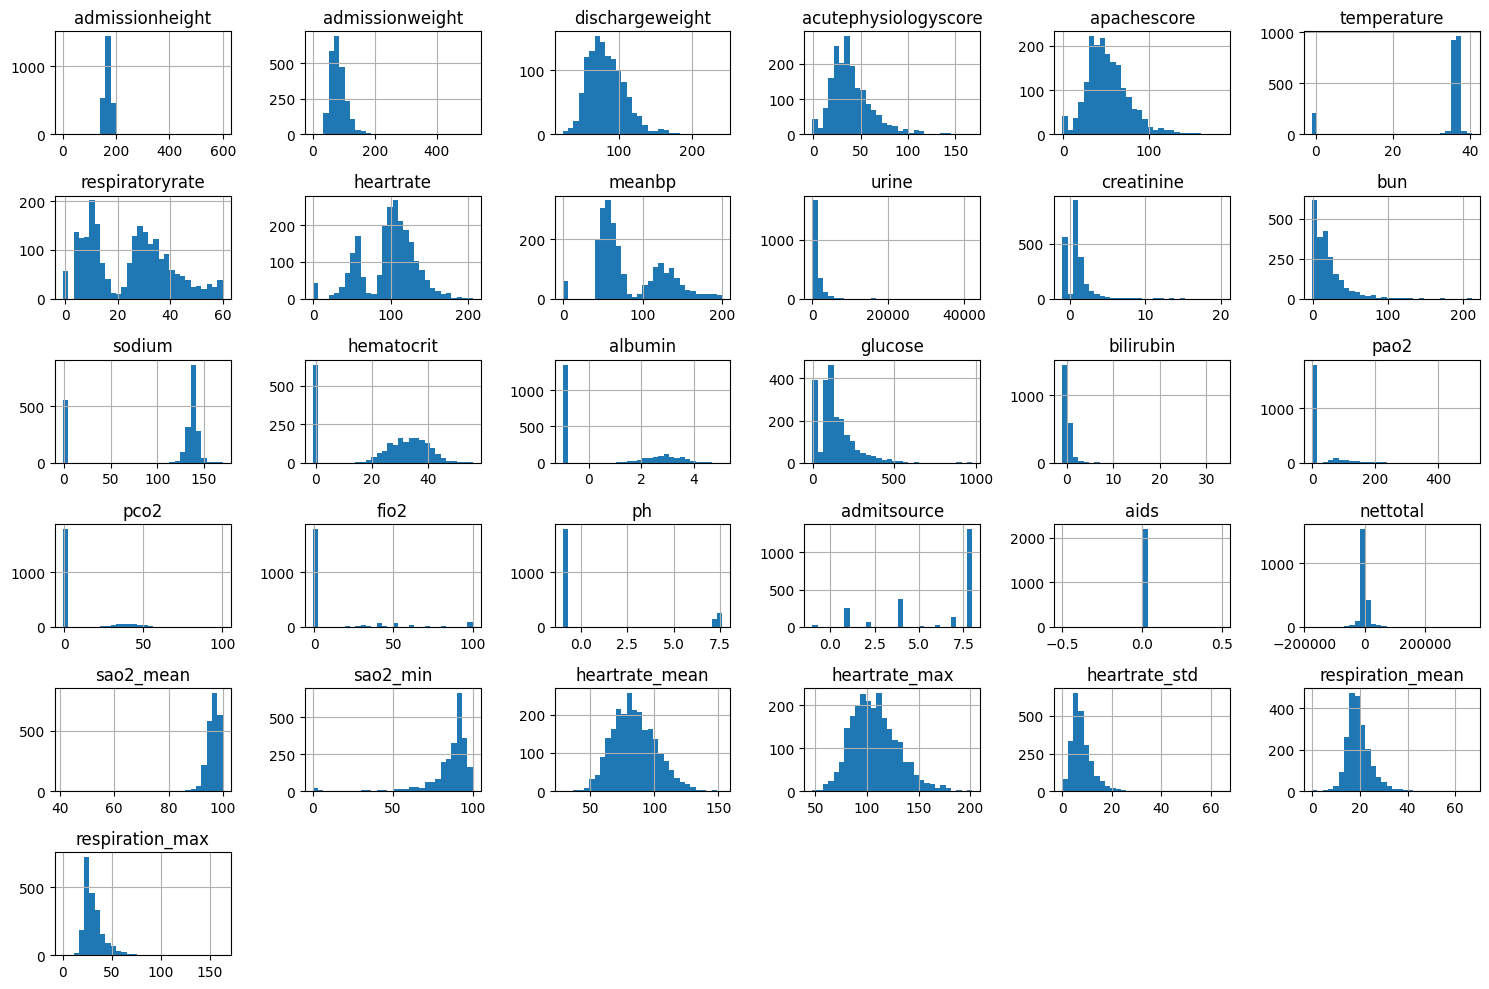

In [13]:
# Select numerical columns

cols_to_exclude = [
    'intubated', 'dialysis', 'hospitalid', 'patientunitstayid',
    'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia',
    'immunosuppression', 'cirrhosis', 'diabetes', 'electivesurgery',
    'activetx', 'bad_outcome', 'ventday1']

# Select numerical columns excluding the ones above
num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
            if col not in cols_to_exclude]
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

**Taking a look at the outliers of the numerical features (minus the binary)**

Must decide later if we want to cap the outliers or keep them in the data.

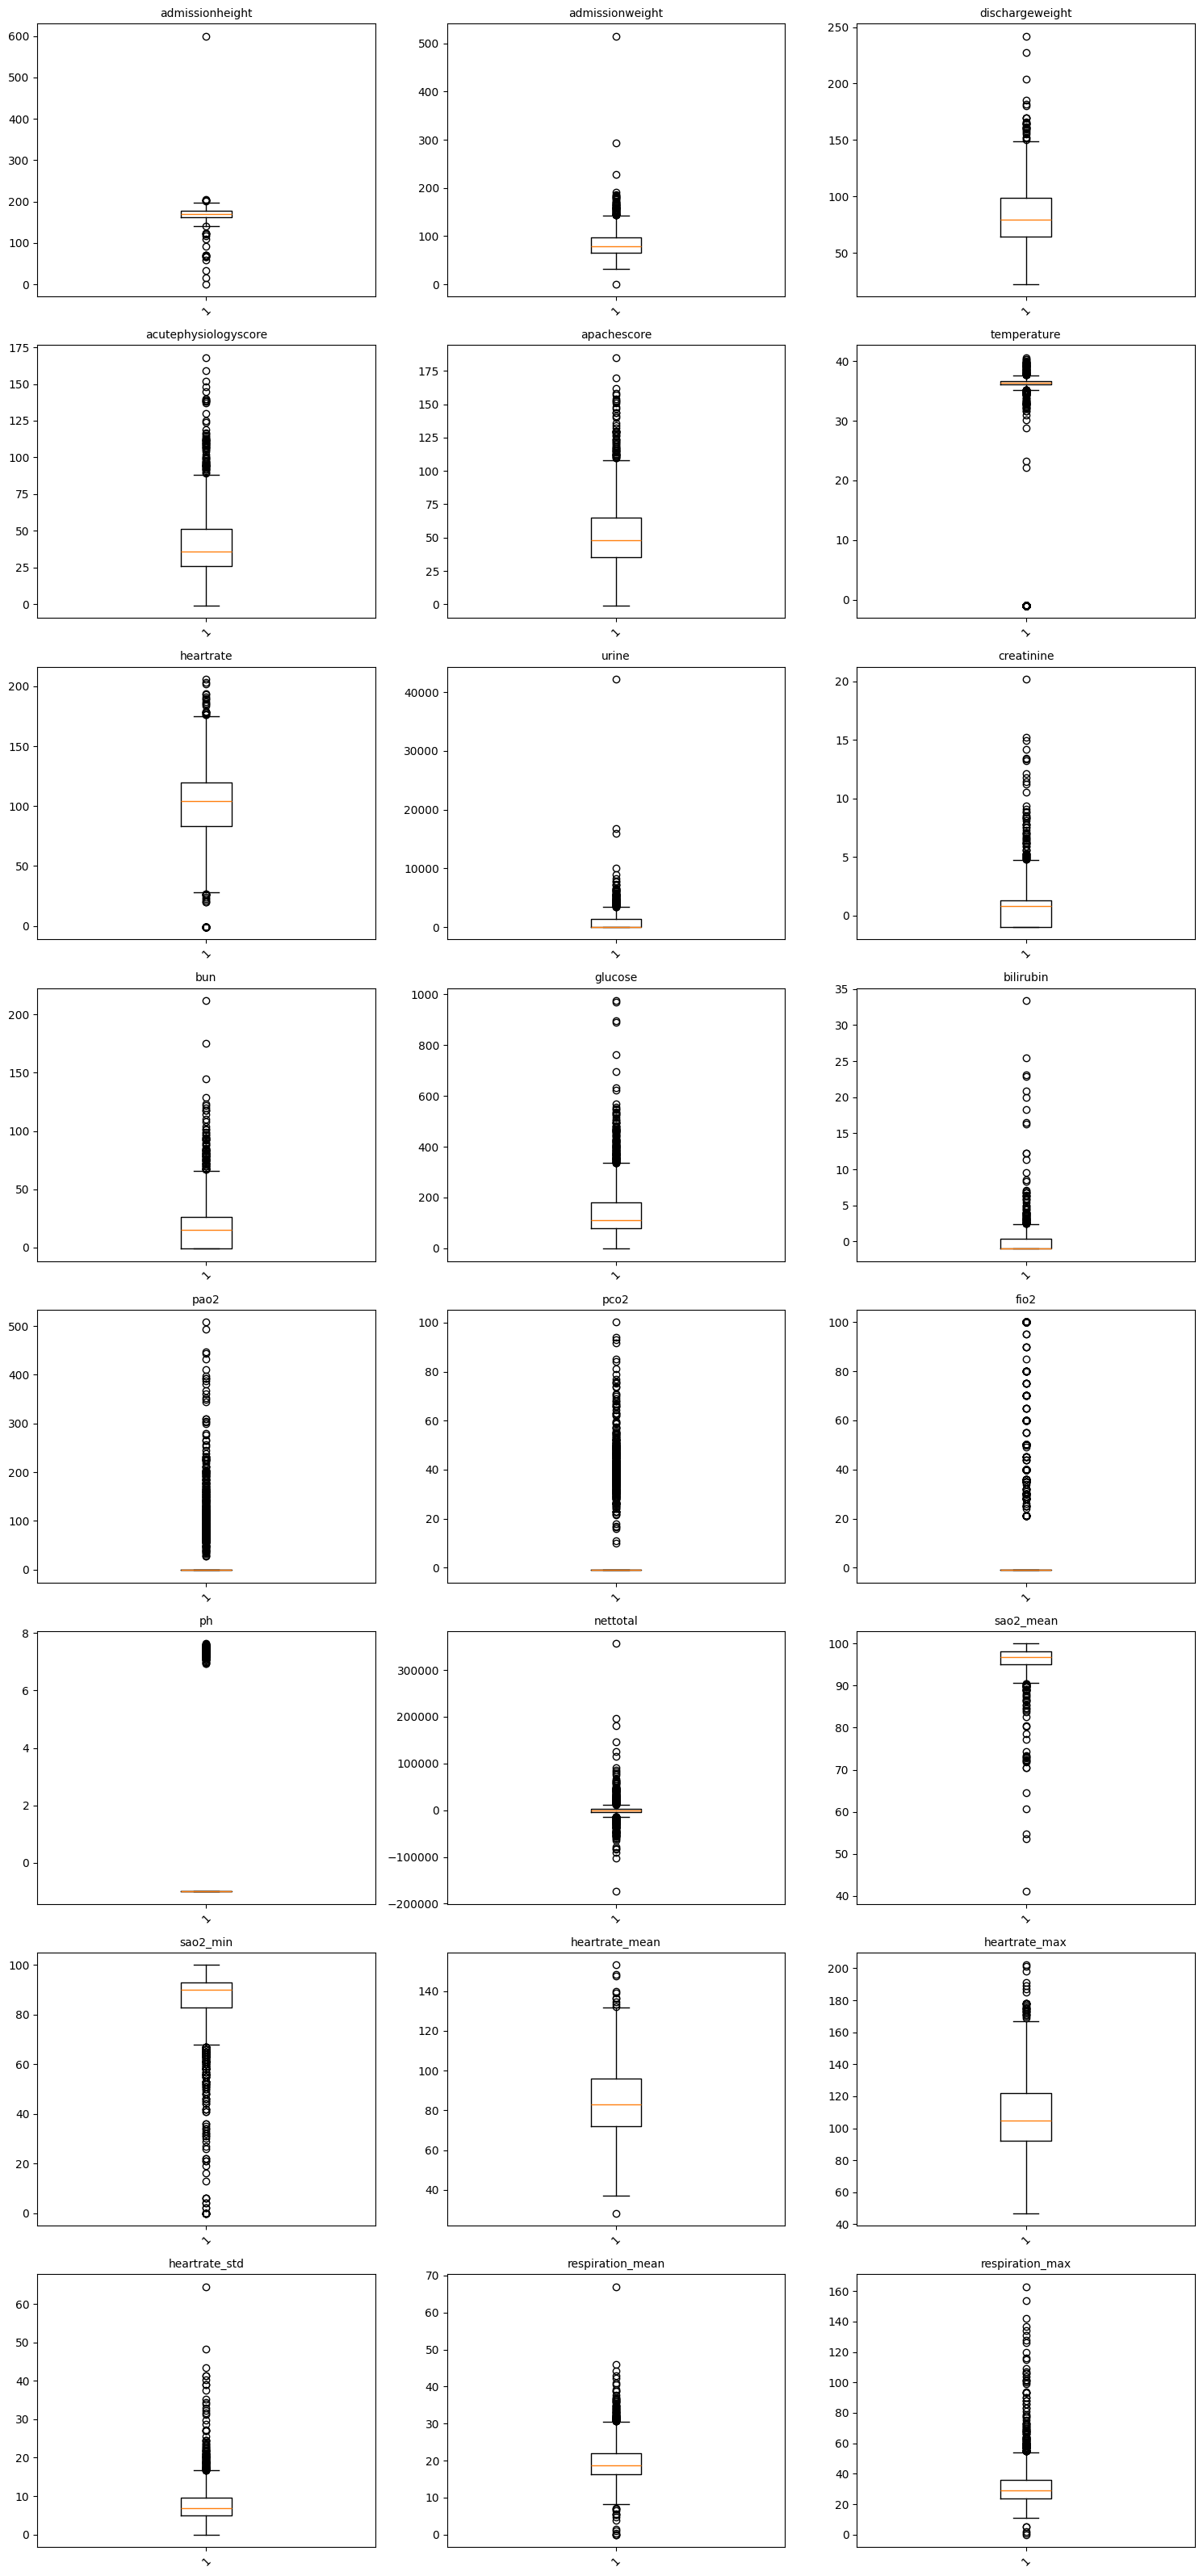

In [14]:
# Columns to exclude from the plot
cols_to_exclude = [
    'intubated', 'dialysis', 'hospitalid', 'patientunitstayid',
    'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia',
    'immunosuppression', 'cirrhosis', 'diabetes', 'electivesurgery',
    'activetx', 'bad_outcome', 'ventday1', 'aids', 'sodium', 'hematocrit', 'albumin', 'meanbp', 'respiratoryrate', 'pH', 'admitsource']

# Select numerical columns that are NOT in the exclude list
num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in cols_to_exclude]

# Define grid layout
n_cols = 3  # plots per row
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot each numerical column
for i, col in enumerate(num_cols):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

The takeaway message here: there are a lot of outliers but that's okay because this is medical data that represents real life scenarios and situations!!

**Visualizing categorical features**

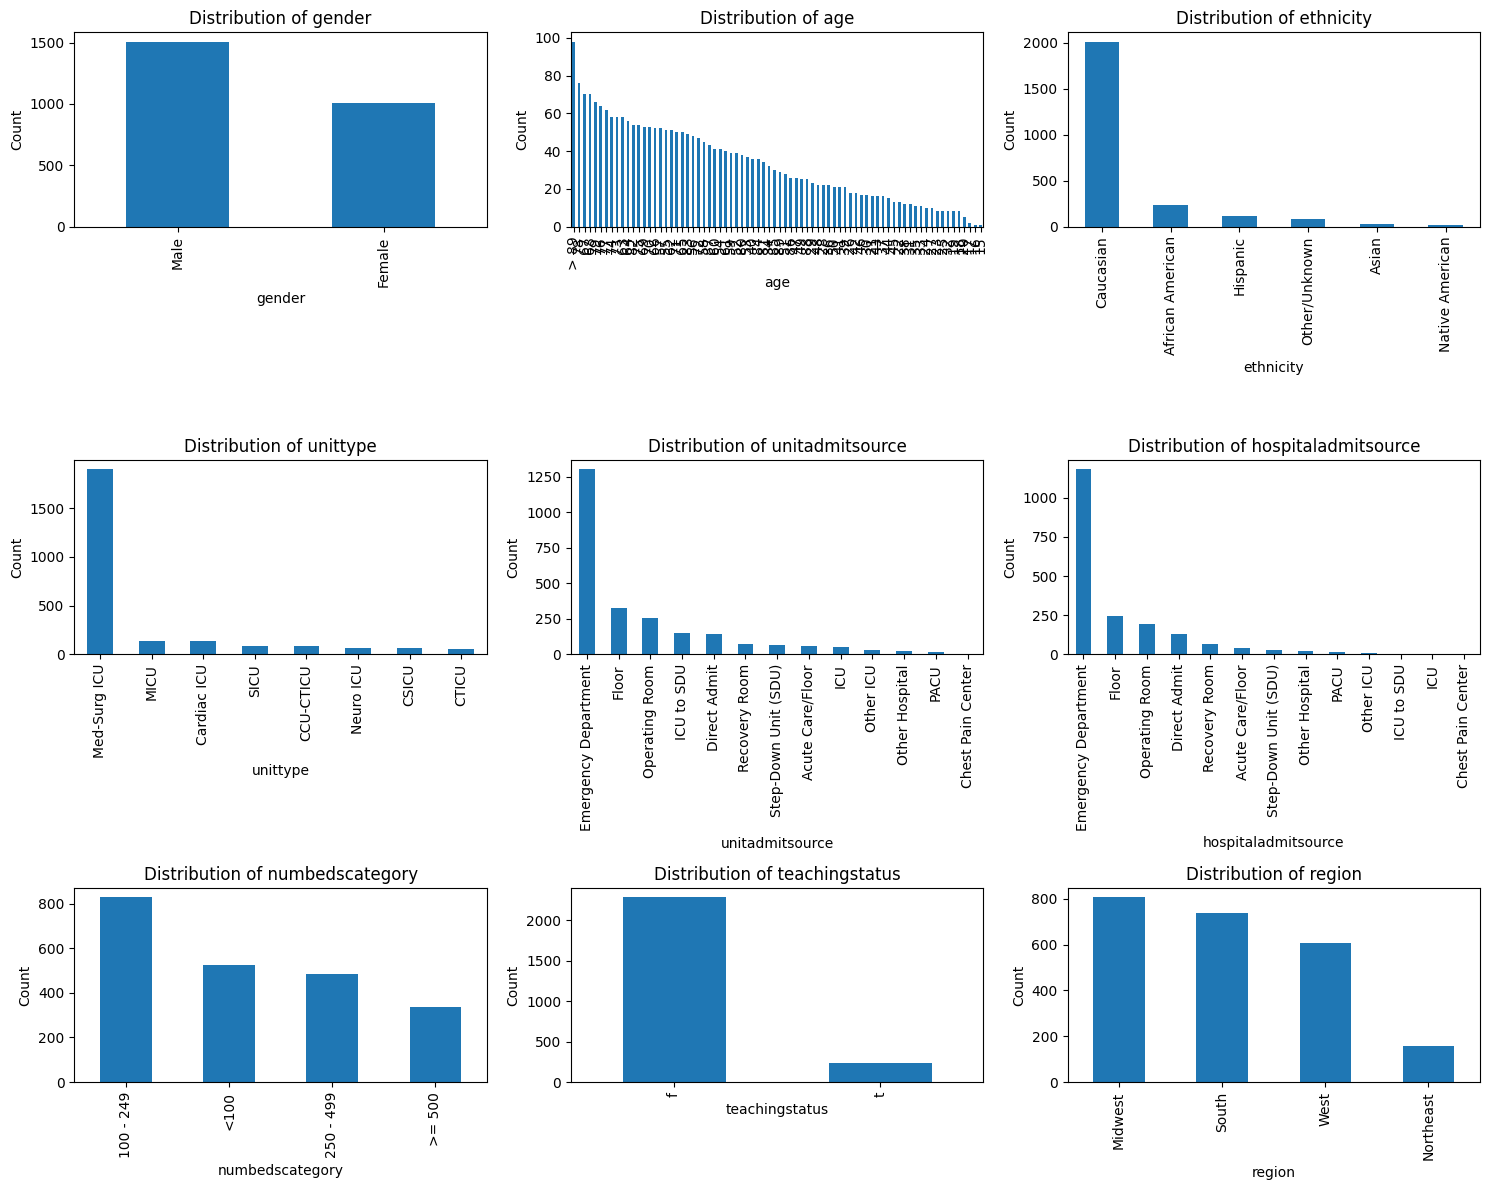

In [15]:
cat_cols = df.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# In case there are fewer than 9 categorical columns
for j in range(len(cat_cols), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Visualizing the class imbalance**

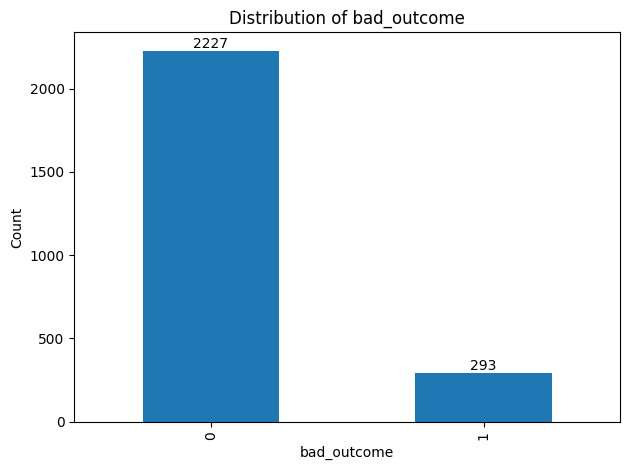

In [16]:
counts = df["bad_outcome"].value_counts()

# Display counts
counts_df = counts.reset_index()
counts_df.columns = ["bad_outcome", "count"]
counts_df

plt.figure()
ax = counts.plot(kind="bar")

# Add text labels above bars
for i, value in enumerate(counts):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.xlabel("bad_outcome")
plt.ylabel("Count")
plt.title("Distribution of bad_outcome")
plt.tight_layout()
plt.show()

In [17]:
# There is a severe class imbalance. bad_outcome = 1 is about 13.15% of the entire dataset

**Target analysis - how features relate to the outcome, like age vs bad_outcome**

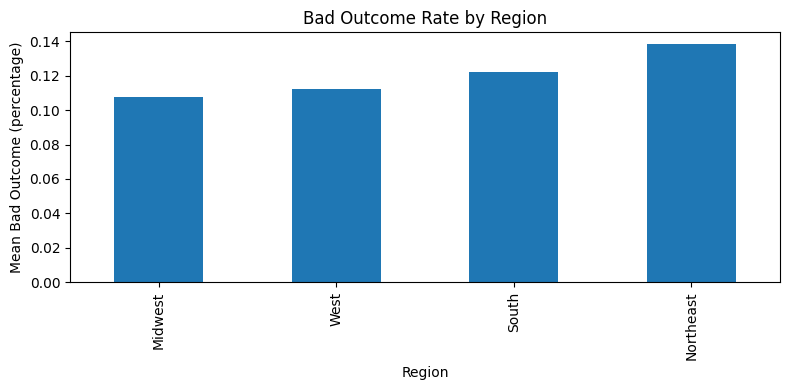

In [18]:
# Percentage of bad_outcome within each Region
region_target = df.groupby("region")["bad_outcome"].mean().sort_values()

plt.figure(figsize=(8,4))
region_target.plot(kind="bar")
plt.title("Bad Outcome Rate by Region")
plt.ylabel("Mean Bad Outcome (percentage)")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

We see that Northeast > South > West > Midwest has most bad outcomes. Midwest is the dominating variable of this feature so this is interesting. 

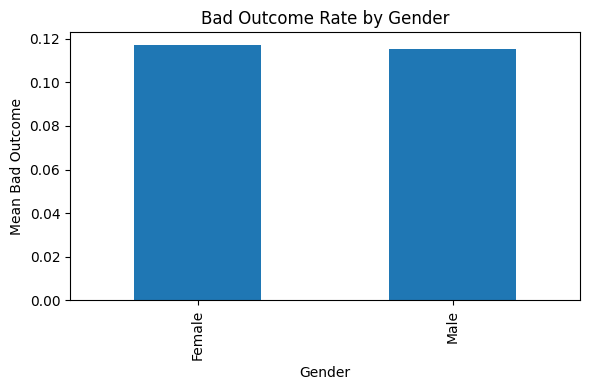

In [19]:
gender_target = df.groupby("gender")["bad_outcome"].mean()

plt.figure(figsize=(6,4))
gender_target.plot(kind="bar")
plt.title("Bad Outcome Rate by Gender")
plt.ylabel("Mean Bad Outcome")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()

Bad outcomes do not discriminate between male and female. It seems like female is slightly larger by just a little bit. There are more males in this dataset.

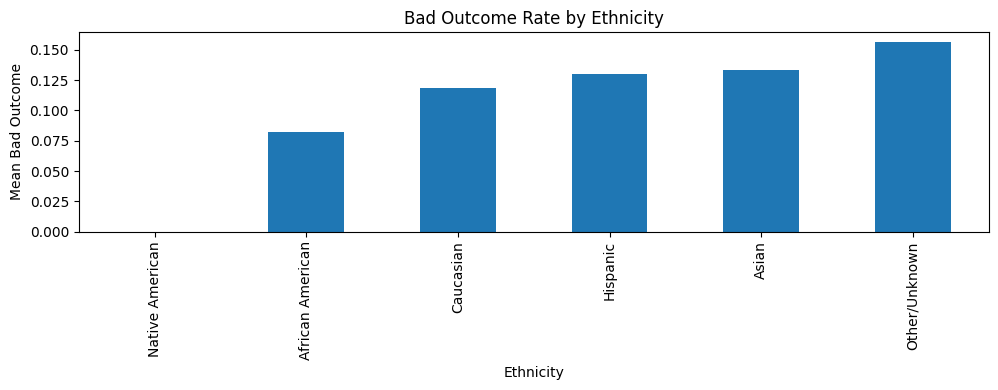

In [20]:
eth_target = df.groupby("ethnicity")["bad_outcome"].mean().sort_values()

plt.figure(figsize=(10,4))
eth_target.plot(kind="bar")
plt.title("Bad Outcome Rate by Ethnicity")
plt.ylabel("Mean Bad Outcome")
plt.xlabel("Ethnicity")
plt.tight_layout()
plt.show()

This is really interesting. Our dominating variable of this ethnicity feature is Caucasian but it seems like Other/Unknown ethnicities > Asian > Hispanic > Caucasian > African American > Native American have more bad outcomes.

In [21]:
# Age

df["age"].unique()

# Will probably replace > 89 with 90 later. 

array(['87', '76', '34', '61', '55', '60', '28', '> 89', '59', '44', '66',
       '41', '63', '57', '52', '23', '73', '39', '20', '29', '71', '18',
       '83', '84', '47', '38', '46', '49', '81', '68', '51', '17', '89',
       '85', '56', '80', '48', '74', '16', '64', '75', '67', '72', '82',
       '77', '78', '58', '88', '53', '54', '65', '69', '62', '50', '42',
       '32', '25', '40', '43', '79', '70', '86', '30', '37', '26', '19',
       '31', '21', '45', nan, '22', '27', '33', '35', '24', '36', '15'],
      dtype=object)

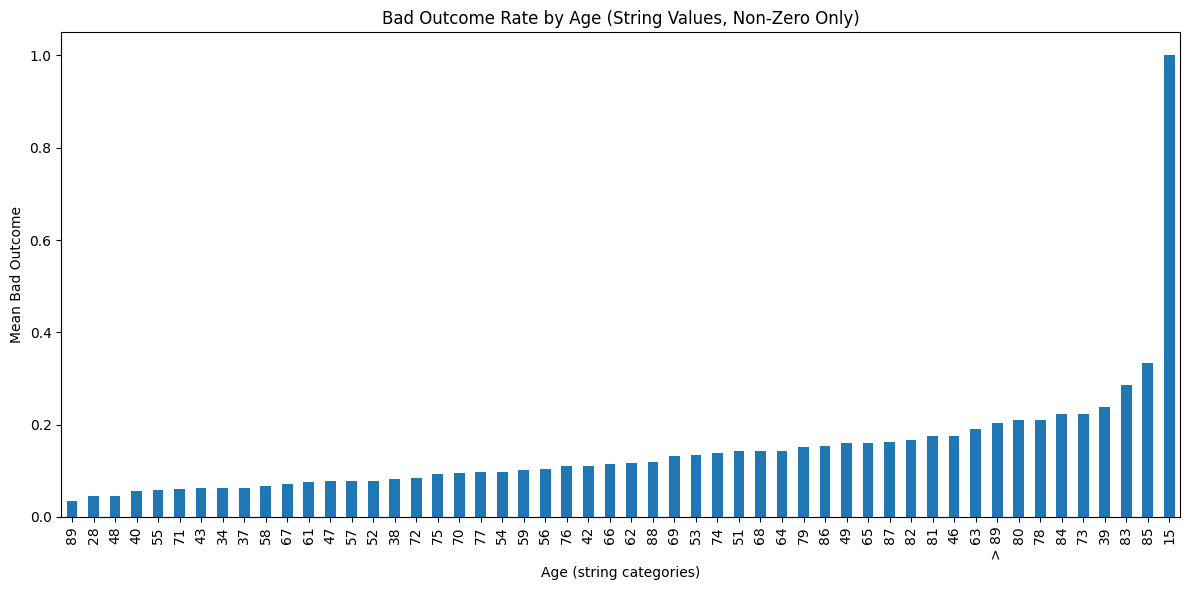

In [24]:
age_target = df.groupby("age")["bad_outcome"].mean()

# Remove ages where the mean bad_outcome is 0
age_target = age_target[age_target > 0]

# Sort after filtering
age_target = age_target.sort_values()

plt.figure(figsize=(12,6))
ax = age_target.plot(kind="bar")

plt.title("Bad Outcome Rate by Age (String Values, Non-Zero Only)") # Looks messier if it includes the ages with mean 0
plt.ylabel("Mean Bad Outcome")
plt.xlabel("Age (string categories)")
plt.tight_layout()
plt.show()

Here we actually see older ages have a higher risk of a bad outcome with middle aged people following. In this dataset (maybe because there are not a lot), there are some 15 year olds who have a 100% of bad_outcome. This may be an outlier that needs to be addressed later. 

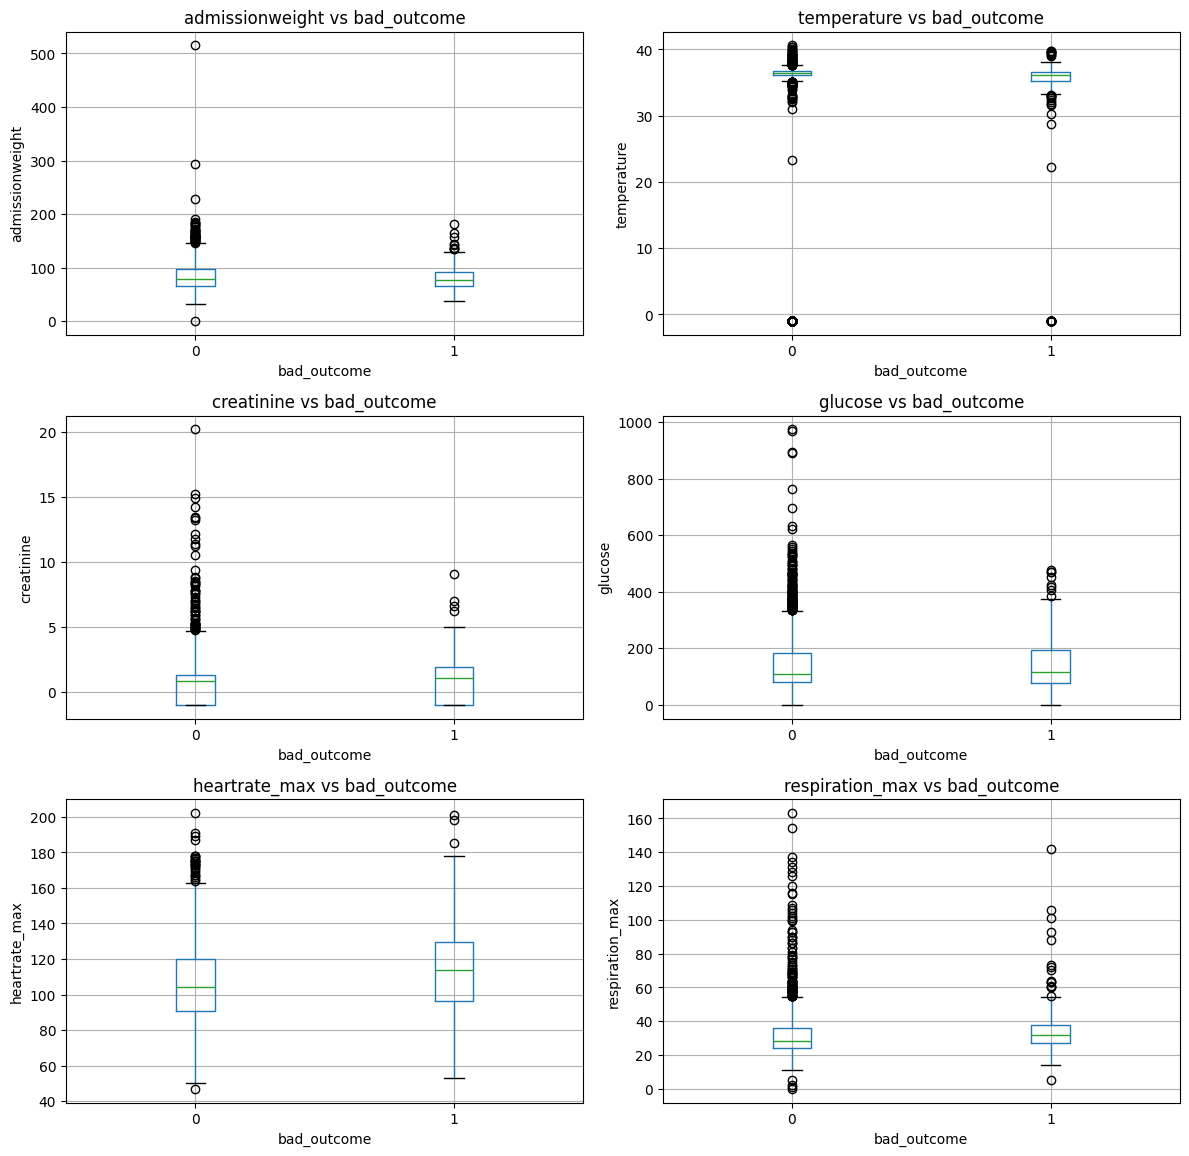

In [25]:
# Bad outcome versus admissionweight, temperature, creatinine, glucose, heartrate_max, respiration_max

features_to_use = [
    "admissionweight", "temperature", "creatinine",
    "glucose", "heartrate_max", "respiration_max"]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(features_to_use):
    df.boxplot(column=col, by="bad_outcome", ax=axes[i])
    axes[i].set_title(f"{col} vs bad_outcome")
    axes[i].set_xlabel("bad_outcome")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.suptitle("")
plt.show()

To read this we must compare:
- Do 0 and 1 look different (if different, might be useful. If similar, then probably not so many differences)
- Higher values may contribute more to risk
- If overlap, then not much relationship
- creatinine vs bad_outcome: If people with bad outcomes have higher creatinine values → it might be a risk factor.
- heartrate_max vs bad_outcome: If the max heart rate is higher in the bad outcome group → it might be important.
- temperature vs bad_outcome: If both groups look the same → temperature doesn’t explain much.
- To note, heartrate in bad_outcome=1 is more than 0, same with creatinine and a little with respiration_max

**Taking a look at correlation and multicollinearity**

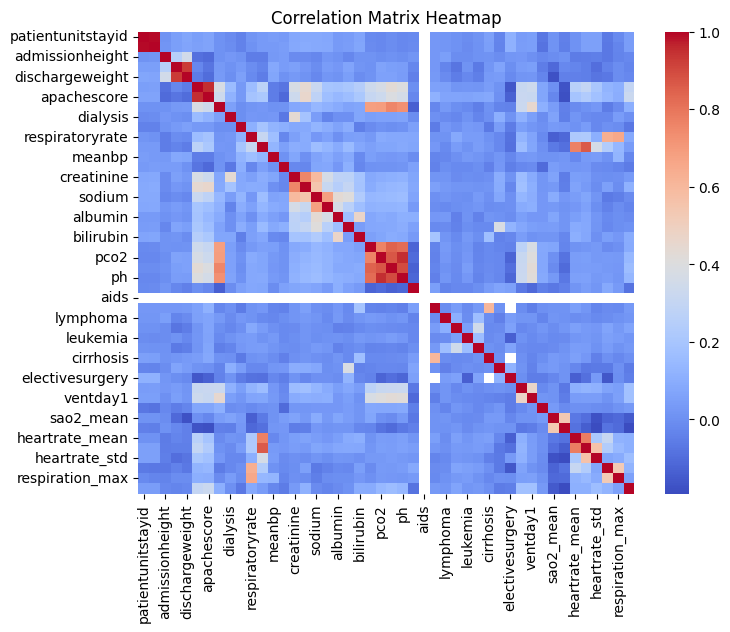

In [26]:
# Calculate correlation matrix

df_numerical=df.select_dtypes(include='number')
correlation_matrix = df_numerical.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

Note that aids has a 0 value so we will probably be able to take this feature out later. To see the relationships more clearly and to check if there is any multicollinearity between our independent variables, we will create a list using VIF to look at their potential for multicollinearity. 

In [27]:
# The graph is too hard to read so let's get the pairs written out with their correlation for each other for threshold >= 0.6
# This threshold is pretty conservative. Usually r > 0.7 is good or r > 0.8. We will also use VIF to support any findings. 
threshold = 0.6
correlated_pairs = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlated_pairs.add((col1, col2, corr_value))

correlated_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation']).sort_values(by='Correlation', key=abs, ascending=False)
print(correlated_df)

           Feature 1             Feature 2  Correlation
14        hospitalid     patientunitstayid     0.993541
3        apachescore  acutephysiologyscore     0.949360
0                 ph                  pco2     0.949168
12   dischargeweight       admissionweight     0.926628
20                ph                  fio2     0.894976
16              fio2                  pco2     0.870967
18     heartrate_max             heartrate     0.864704
10              fio2                  pao2     0.845212
5                 ph                  pao2     0.822021
8      heartrate_max        heartrate_mean     0.777345
1     heartrate_mean             heartrate     0.769581
9               pco2                  pao2     0.763837
19               bun            creatinine     0.757928
15              fio2             intubated     0.755228
6                 ph             intubated     0.727937
13              pco2             intubated     0.688257
17              pao2             intubated     0

In [47]:
# See features that contribute nothing (may remove these features later)

irrelevant_features = []

for col in df.columns:
    if col == 'bad_outcome':
        continue
    if df[col].dtype == 'object' or df[col].nunique() < 10:  # categorical and numeric features with few unique values (treated as categorical)
        contingency = pd.crosstab(df[col], df['bad_outcome'])
        chi2, p, _, _ = chi2_contingency(contingency)
        if p > 0.05:
            irrelevant_features.append(col)
print(irrelevant_features )

['gender', 'ethnicity', 'unittype', 'teachingstatus', 'region', 'dialysis', 'hepaticfailure', 'lymphoma', 'leukemia', 'immunosuppression', 'cirrhosis', 'electivesurgery']


In [28]:
# Using VIF

# Add a constant to the DataFrame (required for VIF calculation)

df_VIF_copy = df_numerical.copy()
df_VIF_copy_no_nulls = df_VIF_copy.dropna()
X = add_constant(df_VIF_copy_no_nulls)

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out the 'const' row as it's not a true feature
vif_data = vif_data[vif_data['feature'] != 'const'].reset_index(drop=True)

# Sort by VIF in descending order for easier identification of highly correlated features
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# VIF > 5 threshold
vif_data_filtered = vif_data[vif_data['VIF'] > 5]
print("Multicollinearity List (VIF per feature) with VIF > 5:")
print(vif_data_filtered)

Multicollinearity List (VIF per feature) with VIF > 5:
                 feature         VIF
1             hospitalid  128.511613
0      patientunitstayid  125.756384
24                    ph   65.515326
22                  pco2   41.112707
6            apachescore   23.424251
5   acutephysiologyscore   23.208265
41         heartrate_max   17.655135
23                  fio2   14.036278
14            creatinine   11.181108
40        heartrate_mean    9.104449
21                  pao2    8.950669
11             heartrate    7.608703
16                sodium    7.547783
7              intubated    7.125814
15                   bun    6.769963
20             bilirubin    6.602960
3        admissionweight    6.281056
4        dischargeweight    5.762315


C:\Users\Marielle\anaconda3\envs\tf_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF > 5 is considered moderate multicollinearity and VIF > 10 is severe multicollinearity. Features with a variance inflation factor that is between 5-10 should be investigated. This is because we do not want to hurt the model, they can still add insight. However, features with a variance inflation factor of greater than 10 should be removed since it may make the coefficients unstable and the model less reliable.

- **Investigate:** dischargeweight, admissionweight, bilirubin, bun, intubated, sodium, heartrate, pao2, heartrate_mean
- **Possibly Remove:** creatinine, fio2, heartrate_max, acutephysiologyscore, apachescore, pco2, ph

## **Part 3: Reference Baseline**

**Baseline created using logistic regression as a base model**

In [29]:
# Create a copy of df for this rough baseline

baseline_df=df.copy()

In [30]:
# Drop ID-like columns
cols_to_drop=["hospitalid", "patientunitstayid"] # This will skew the model
baseline_df_clean = baseline_df.drop(columns=[c for c in cols_to_drop if c in baseline_df.columns])

# Split features and target
X=baseline_df_clean.drop("bad_outcome", axis=1)
y=baseline_df_clean["bad_outcome"]

# Identify column types
categorical_cols=X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols=X.select_dtypes(include=["number", "bool"]).columns.tolist()

# Preprocessing pipeline with imputation, this roughly replaces NaN in numerical features with the median and mode in the categorical features
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols)])

In [31]:
# Logistic regression pipeline
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=1000))]) # PLEASE NOTE THIS IS WITHOUT CLASS_WEIGHT=BALANCED

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Fit model
model.fit(X_train, y_train)

# Evaluate
preds=model.predict(X_test)
probs=model.predict_proba(X_test)[:, 1]

Accuracy: 0.9087301587301587
ROC AUC: 0.8609026852028185

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       445
           1       0.81      0.29      0.42        59

    accuracy                           0.91       504
   macro avg       0.86      0.64      0.69       504
weighted avg       0.90      0.91      0.89       504



<Figure size 600x600 with 0 Axes>

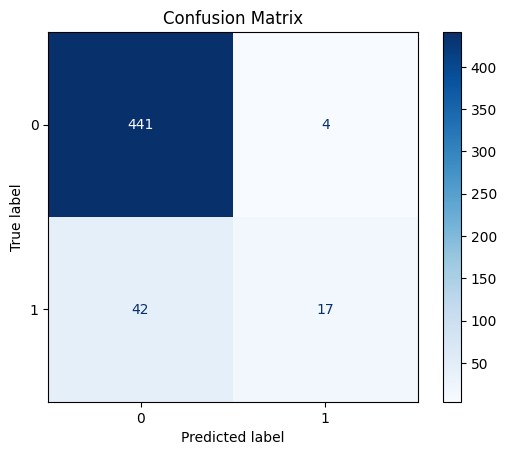

In [32]:
# Print metrics
print("Accuracy:", accuracy_score(y_test, preds)) # Don't really care about accuracy for this problem
print("ROC AUC:", roc_auc_score(y_test, probs))
print("\nClassification Report:\n")
print(classification_report(y_test, preds))

# Confusion matrix visualization
cm=confusion_matrix(y_test, preds)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 6))
disp.plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

**Evaluation**
- Accuracy is ~0.91, but that is misleading in our imbalanced dataset
- ROC-AUC of 0.86 is strong for a baseline model, meaning it can distinguish between the classes fairly well
- For class 0:
    - Precision = 0.91: Good at correctly identifying non–bad outcomes
    - Recall = 0.99: Almost perfect at not raising false alarms
    - F1 = 0.95: Really good
- For class 1:
    -  Precision = 0.81: When it predicts a bad outcome, it’s usually right
    -  Recall = 0.29: It only finds 29% of real bad outcomes
    -  F1 = 0.42: Tradeoff between precision/recall is low

We can see that this baseline model is really good at classifying those with good outcomes (bad_outcome=0). Note that this baseline logistic regression model is not using the "class_weight=balanced" argument. I wonder if there is any overfitting going on with the class 0 patients or if the model is just guessing 0 for those who are actually 1 because the majority of the dataset is 0. We will explore this later. Overall this baseline model does a really good job with good outcomes rather than bad. The primary metric to focus on will be Recall since missclassifying a patient as healthy whenever they are not can be fatal. So metric priority is recall > precision > F1 and a good ROC-AUC score.

## **Part 4: Data Preprocessing and Cleaning**
### **CHECKPOINT 1 - Load from here**
The beast.

In [66]:
df = pd.read_csv("mergeICU_db.csv")
df.shape

(2520, 55)

Before starting, here is a to-do list of what to do:
- Remove aids feature (every patient in this dataset does not have aids)
- Replace any -1 values with 0
- Remove any features that do not make sense in the dataset, like teaching status
- Check the relationship between unitadmitsource, hospitaladmitsource, admitsource
- Fix age column (it is read as a string, but it is numeric)
- Check if there are any negative values when there shouldn't be
- **Keep outliers because they represent real, chritical physiological events and could be correlated with bad_outcome**
- Work on missing data (Median imputation for numerical and Unknown for categorical features)
    - Avoid filling with 0 or any other value unless it means something clinically
    - Do not fill with mean because there are outliers that could skew data and distort real signals
    - KNN imputation has the risk of producing combinations that are medically inaccurate
    - **Most medical professions use multiple imputation on clinical research but that may be computationally expensive for this project so we will stick with single imputation using the median. This can be mentioned in the future works section**
- Change admitsource to categorical
- One-hot (if no ordinal data) encode categorical variables
- Drop variables with extremely high VIFs
- Check that everything is good (no missing values, appropriate dtypes, remove unecessary features)
- Note which features to keep for bias/fairness check (region, hospitalid, etc.) but do **NOT** include them in the models
- Scale and standardize (save a df_unscaled and a df_scaled)
- Feature engineering will be later after this basic cleaning!

**Remove aids feature**

In [67]:
df.drop(columns=["aids"], inplace=True)
df.shape

(2520, 54)

**Replace any -1 values with 0 (if it medically makes sense) OR NaN**

We have to see which features treat -1's as a "no measurement recorded" and which features treat it as a 0 in binary.

In [68]:
# Remember that
out=(
    df.eq(-1).sum()                     # count -1 per column
      .to_frame("count_minus1")         # convert to DataFrame
      .assign(dtype=df.dtypes)          # add dtype info
      .query("count_minus1 != 0"))       # exclude zeros)

print(out)

# These are the features that have -1's

                      count_minus1    dtype
acutephysiologyscore            41  float64
apachescore                     41  float64
temperature                    213  float64
respiratoryrate                 57  float64
heartrate                       42  float64
meanbp                          60  float64
urine                         1140  float64
creatinine                     561  float64
bun                            565  float64
sodium                         555  float64
hematocrit                     638  float64
albumin                       1351  float64
glucose                        388  float64
bilirubin                     1442  float64
pao2                          1800  float64
pco2                          1800  float64
fio2                          1800  float64
ph                            1800  float64
admitsource                     20  float64
nettotal                         2  float64


The factors that treat -1 as no measurement recorded: acutephysiologyscore, apachescore, temperature, respiratoryrate, heartrate, meanbp, urine, creatinine, bun, sodium, hematocrit, albumin, glucose, bilirubin, pao2, pco2, fio2, ph, admitsource, nettotal (basically all of them oops, was just making sure!) **But do not replace with 0 because 0 is a real medical valuable and in this case it just means missing but if it is set to 0, that could indicate that a patient has undergone a bad outcome**

In [69]:
cols_with_minus1 = ["acutephysiologyscore", "apachescore", "temperature", "respiratoryrate", "heartrate", "meanbp", "urine", "creatinine",
    "bun", "sodium", "hematocrit", "albumin", "glucose", "bilirubin", "pao2", "pco2", "fio2", "ph", "admitsource", "nettotal"]

df[cols_with_minus1] = df[cols_with_minus1].replace(-1, np.nan)

# We replaced these columns with -1 to NaN

**Remove any features that do not make sense in the dataset**

In [70]:
# Remember that
irrelevant_features = []

for col in df.columns:
    if col == 'bad_outcome':
        continue
    if df[col].dtype == 'object' or df[col].nunique() < 10:  # categorical and numeric features with few unique values (treated as categorical)
        contingency = pd.crosstab(df[col], df['bad_outcome'])
        chi2, p, _, _ = chi2_contingency(contingency)
        if p > 0.05:
            irrelevant_features.append(col)
print(irrelevant_features )

['gender', 'ethnicity', 'unittype', 'teachingstatus', 'region', 'dialysis', 'hepaticfailure', 'lymphoma', 'leukemia', 'immunosuppression', 'cirrhosis', 'electivesurgery']


I'm going to go by each one of these and see if it makes sense and all the other features as well. 

In [71]:
print(df.columns)

Index(['patientunitstayid', 'gender', 'age', 'ethnicity', 'hospitalid',
       'unittype', 'admissionheight', 'admissionweight', 'dischargeweight',
       'unitadmitsource', 'hospitaladmitsource', 'numbedscategory',
       'teachingstatus', 'region', 'acutephysiologyscore', 'apachescore',
       'intubated', 'dialysis', 'temperature', 'respiratoryrate', 'heartrate',
       'meanbp', 'urine', 'creatinine', 'bun', 'sodium', 'hematocrit',
       'albumin', 'glucose', 'bilirubin', 'pao2', 'pco2', 'fio2', 'ph',
       'admitsource', 'hepaticfailure', 'lymphoma', 'metastaticcancer',
       'leukemia', 'immunosuppression', 'cirrhosis', 'diabetes',
       'electivesurgery', 'activetx', 'ventday1', 'nettotal', 'sao2_mean',
       'sao2_min', 'heartrate_mean', 'heartrate_max', 'heartrate_std',
       'respiration_mean', 'respiration_max', 'bad_outcome'],
      dtype='object')


Our goal here is to predict ICU patient poor outcomes (death or readmission) using demographic, clinical, and physiological data. From the features listed above, the ones that do not contribute meaningfully to the data (subjective, of course) are: 
- teachingstatus, numbedscategory

Features to keep for bias/fairness check but to NOT include in the model:
- region, hospitalid, unitadmitsource, hospitaladmitsource (check relationship between unitadmitsource and hospitaladmitsource), admitsource, unittype

In [72]:
# Drop columns
df = df.drop(columns=['teachingstatus', 'numbedscategory'])
df.shape

(2520, 52)

**Check the relationship between unitadmitsource, hospitaladmitsource, admitsource and remove any if needed**

Cramér’s V is a statistic that measures the strength of association between two categorical variables. It’s based on the Chi-square statistic, which tests whether two categorical variables are independent. We want to know how redundant are these features with each other? (multicollinearity) and how much do they relate to the target (bad_outcome). This coefficient is used widely in medical data and clinical research for categorical variables. It does not imply causation, only association.

In [73]:
# Checking the relationship between unitadmitsource and hospitaladmitsource, which are categorical variables
# Contingency table
contingency_table = pd.crosstab(df['unitadmitsource'], df['hospitaladmitsource'])
# print(contingency_table)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square: {chi2}, p-value: {p}")

# Cramer's V (measure of association)
n = contingency_table.sum().sum()
phi2 = chi2 / n
r, k = contingency_table.shape
cramers_v = np.sqrt(phi2 / min(r-1, k-1))
print(f"Cramer's V: {cramers_v}")

Chi-square: 10599.59565985253, p-value: 0.0
Cramer's V: 0.6775658241918705


This test shows that these 2 categorical variables are significant, meaning they are NOT independent of each other. Therefore we can remove one or the other. But first, let's check how this relates to the numerical feature admitsource, which seems to be related to unitadmitsource and hospitaladmitsource. Now below we will use an ANOVA for a categorical independent variable and a numerical dependent variable because Cramer's V only really works for categorical variables.

In [74]:
# Seeing the relationship between the hospitaladmitsource categorical variable and admit source numerical feature
model = ols('admitsource ~ C(hospitaladmitsource)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                             sum_sq      df           F  PR(>F)
C(hospitaladmitsource)  8113.882404    12.0  450.999913     0.0
Residual                2479.742071  1654.0         NaN     NaN


In [75]:
# Seeing the relationship between the unitadmitsource categorical variable and admit source numerical feature
model = ols('admitsource ~ C(unitadmitsource)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq      df             F  PR(>F)
C(unitadmitsource)  1.429040e+04    12.0  5.159742e+29     0.0
Residual            5.012968e-24  2172.0           NaN     NaN


From this we can conclude that unitadmitsource and admitsource has a 1:1 relationship. We can remove unitadmitsource. We can also remove hospitaladmitsource because admitsource captures that relationship already and it would be redundant. 

In [76]:
# Remove unitadmitsource and hospitaladmitsource from df
df = df.drop(columns=['unitadmitsource', 'hospitaladmitsource'])
df.shape

(2520, 50)

**Fix age column (change string to numeric)**

In [77]:
# Unique values in age feature
print(df['age'].unique())

['87' '76' '34' '61' '55' '60' '28' '> 89' '59' '44' '66' '41' '63' '57'
 '52' '23' '73' '39' '20' '29' '71' '18' '83' '84' '47' '38' '46' '49'
 '81' '68' '51' '17' '89' '85' '56' '80' '48' '74' '16' '64' '75' '67'
 '72' '82' '77' '78' '58' '88' '53' '54' '65' '69' '62' '50' '42' '32'
 '25' '40' '43' '79' '70' '86' '30' '37' '26' '19' '31' '21' '45' nan '22'
 '27' '33' '35' '24' '36' '15']


In [78]:
# Convert >89 years old to just 90
df['age'] = df['age'].replace('> 89', '90')

In [79]:
# Now convert ages to numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')

In [80]:
df['age'].isna().sum()

np.int64(4)

In [81]:
# Use median imputation for the 4 missing age variables
df['age'] = df['age'].fillna(df['age'].median())

**Check if there are any negative values when there shouldn't be in numeric columns**

In [82]:
df.select_dtypes(include='number').lt(0).any().any()

# There is

np.True_

In [83]:
# Check which feature has the negative value
df.select_dtypes(include='number').lt(0).any()[lambda x: x]

# It is nettotal

nettotal    True
dtype: bool

In [84]:
df['nettotal'].unique()

# This is fine since it is NET total for intake output I/O values for patients! We do not have to change anything

array([ -500.  ,  3025.  ,  4201.  , ...,  2299.5 ,   786.9 , -1333.09])

**Work on missing data (median imputation for numerical and "Unknown" for categorical features)**

We use median imputation rather than mean because median is robust to outliers and there are definitely outliers in this dataset!

In [85]:
# Null summary with missingness and dtypes

null_summary = (df.isnull().sum().reset_index().rename(columns={'index': 'Column', 0: 'MissingCount'}))
null_summary['MissingPercent'] = (null_summary['MissingCount'] / len(df)) * 100

# Add dtypes
null_summary['dtype'] = null_summary['Column'].map(df.dtypes)

# Filter only columns with missing values and sort
null_summary = null_summary[null_summary['MissingCount'] > 0]
null_summary = null_summary.sort_values(by='MissingPercent', ascending=False)
print(null_summary)

# Also note earlier we already filled the age nan's column with median 

                  Column  MissingCount  MissingPercent    dtype
38       electivesurgery          2178       86.428571  float64
28                  fio2          2115       83.928571  float64
27                  pco2          2115       83.928571  float64
29                    ph          2115       83.928571  float64
26                  pao2          2115       83.928571  float64
25             bilirubin          1757       69.722222  float64
23               albumin          1666       66.111111  float64
18                 urine          1455       57.738095  float64
8        dischargeweight          1284       50.952381  float64
22            hematocrit           953       37.817460  float64
20                   bun           880       34.920635  float64
19            creatinine           876       34.761905  float64
21                sodium           870       34.523810  float64
10  acutephysiologyscore           723       28.690476  float64
11           apachescore           723  

In [86]:
# Fill categorical variable nan's with "Unknown" 

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

For our missingness in the numerical features, we have to be more careful. We have to decide if we want to take out that feature because it's missingness is too much adn we also have to be aware of the -1 values that indicated the data was not entered in from earlier changed to nan. We will create categories for each case and act based off of that:
- High missingness labs (~50%+)
    - We want to preserve medical meaning so to prevent skewing the data, we will add a missingness indicator.
    - Sometimes when a patient is not that sick, they won't get that test done and that is probably why features like pao2 are missing, because the patient did not need it
    - Missingness = clinical signal
    - Imputing + adding missingness flag does NOT skew the data
- Moderate missingness labs (~10-40%)
    - Add a missingness flag
- Low missingness labs (<10%)
    - Does not need a missingness flag as there is minimal impact on the dataset
- Special cases missingness: comorbidity variables and electivesurgery (binary)

**Note:** We will add a missingness flag to all lab vitals EXCEPT to the low missingness lab vitals since they have low impact. We will include acutephysiologyscore and apachescore since they take from the lab vitals.

In [87]:
# Addressing high missingness lab vitals

high_missing_cols = ["fio2","pco2","pao2","ph","bilirubin","albumin","urine","dischargeweight"]

for col in high_missing_cols:
    df[col + "_missing"] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

In [88]:
df.shape

(2520, 58)

In [89]:
df.head()

,patientunitstayid,gender,age,ethnicity,hospitalid,unittype,admissionheight,admissionweight,dischargeweight,region,...,respiration_max,bad_outcome,fio2_missing,pco2_missing,pao2_missing,ph_missing,bilirubin_missing,albumin_missing,urine_missing,dischargeweight_missing
0,141764,Female,87.0,Caucasian,59,Med-Surg ICU,157.5,NaN,79.55,Midwest,...,NaN,0,1,1,1,1,1,1,1,1
1,141765,Female,87.0,Caucasian,59,Med-Surg ICU,157.5,46.5,45.00,Midwest,...,39.0,0,1,1,1,1,1,1,1,0
2,143870,Male,76.0,Caucasian,68,SICU,167.0,77.5,79.40,Midwest,...,86.0,0,1,1,1,1,1,1,1,0
3,144815,Female,34.0,Caucasian,56,Med-Surg ICU,172.7,60.3,60.70,Midwest,...,42.0,0,1,1,1,1,0,0,1,0
4,145427,Male,61.0,Caucasian,68,SICU,177.8,91.7,93.10,Midwest,...,41.0,0,1,1,1,1,1,1,1,0


In [90]:
# Addressing medium missingness lab vitals

medium_missing_cols = ["hematocrit","bun","creatinine","sodium","acutephysiologyscore","apachescore","glucose","temperature",
                      "meanbp", "respiratoryrate", "respiration_mean", "respiration_max", "heartrate"]

for col in medium_missing_cols:
    df[col + "_missing"] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

In [91]:
# Low missing columns and other numericals

low_missing_cols = ["nettotal", "sao2_mean", "sao2_min", "admissionweight", "heartrate_std", "heartrate_mean", "heartrate_max", "admissionheight"]

for col in low_missing_cols:
    df[col] = df[col].fillna(df[col].median())

In [92]:
# Special case binary columns

binary_cols = ["electivesurgery", "lymphoma", "cirrhosis", "dialysis", "intubated", "hepaticfailure", "ventday1", "activetx", "diabetes",
               "leukemia", "immunosuppression", "metastaticcancer"]

for col in binary_cols:
    df[col] = df[col].fillna(0)

In [93]:
df.isnull().values.any()

# This is probably referring to the admitsource column which we will fix next

np.True_

In [94]:
df.shape

# There are now 71 columns! May have to do some PCA later or get rid of some features. We will see!

(2520, 71)

**Change admitsource to categorical**

In [95]:
df['admitsource'].unique()

array([nan,  8.,  1.,  4.,  7.,  6.,  2.,  5.,  3.])

In [96]:
# Fill nans with Unknown
df['admitsource'] = df['admitsource'].fillna('Unknown')

In [97]:
# Convert float numbers to integers, then to strings, and add 'Unit ' prefix
df['admitsource'] = df['admitsource'].apply(lambda x: f"Unit {int(x)}" if str(x).replace('.', '', 1).isdigit() else x)

In [98]:
df['admitsource'] = df['admitsource'].astype('object')

In [99]:
df['admitsource'].unique()

array(['Unknown', 'Unit 8', 'Unit 1', 'Unit 4', 'Unit 7', 'Unit 6',
       'Unit 2', 'Unit 5', 'Unit 3'], dtype=object)

**One-hot (if no ordinal data) encode categorical variables**

In [100]:
object_cols = df.select_dtypes(include='object').columns
print(object_cols)

Index(['gender', 'ethnicity', 'unittype', 'region', 'admitsource'], dtype='object')


In [101]:
df.shape

(2520, 71)

Since region, admitsource, and unittype are going to be used for bias and fairness check instead of being put in the model (they may introduce noise or bias), we will only one-hot encode gender and ethnicity.

In [102]:
df['gender'].unique()

array(['Female', 'Male', 'Unknown'], dtype=object)

In [103]:
# Count the occurrences of each unique value
gender_distribution = df['gender'].value_counts()

print(gender_distribution)

gender
Male       1508
Female     1008
Unknown       4
Name: count, dtype: int64


In [104]:
# Feature engineering - changing Unknown to the mode (male)

df['gender'] = df['gender'].replace('Unknown', 'Male')
gender_distribution = df['gender'].value_counts()
print(gender_distribution)

gender
Male      1512
Female    1008
Name: count, dtype: int64


In [105]:
df['ethnicity'].unique()

array(['Caucasian', 'Hispanic', 'Asian', 'African American', 'Unknown',
       'Native American', 'Other/Unknown'], dtype=object)

In [106]:
ethnicity_distribution = df['ethnicity'].value_counts()
print(ethnicity_distribution)

ethnicity
Caucasian           2010
African American     231
Hispanic             115
Other/Unknown         83
Unknown               39
Asian                 30
Native American       12
Name: count, dtype: int64


In [107]:
# Feature engineering - Combining Hispanic, Asian, African American, Native American, and Unknown into a minority group

df["ethnicity_collapsed"] = df["ethnicity"].apply(
    lambda x: "Caucasian" if x == "Caucasian" else "Minority_Other")

df = df.drop(columns=["ethnicity"])

df = pd.get_dummies(df, columns=["ethnicity_collapsed"], drop_first=False)

In [108]:
# Change Other/Unknown to just Unknown because they both mean the same thing
# df['ethnicity'] = df['ethnicity'].replace({'Other/Unknown': 'Unknown'})

In [109]:
# df['ethnicity'].unique()

In [110]:
# categorical_cols_to_encode = ['gender', 'ethnicity']
categorical_cols_to_encode = ['gender']
df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=False) # One-hot encodes, does not drop Female or African American (BEFORE FEATURE ENGINEERING)

In [111]:
# Convert all boolean columns to 0/1
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [112]:
df.shape

(2520, 73)

In [113]:
# Rename ethnicity_collapsed_Caucasian and ethnicity_collapsed_Minority_Other to ethnicity_Caucasian and ethnicity_Minority_Other
# Also lowercase the gender feature names to keep it consistent

df = df.rename(columns={
    "ethnicity_collapsed_Caucasian": "ethnicity_caucasian",
    "ethnicity_collapsed_Minority_Other": "ethnicity_minority_other",
    "gender_Female" : "gender_female",
    "gender_Male" : "gender_male"})

In [115]:
df.head()

,patientunitstayid,age,hospitalid,unittype,admissionheight,admissionweight,dischargeweight,region,acutephysiologyscore,apachescore,...,temperature_missing,meanbp_missing,respiratoryrate_missing,respiration_mean_missing,respiration_max_missing,heartrate_missing,ethnicity_caucasian,ethnicity_minority_other,gender_female,gender_male
0,141764,87.0,59,Med-Surg ICU,157.5,79.3,79.55,Midwest,36.0,49.0,...,1,1,1,1,1,1,1,0,1,0
1,141765,87.0,59,Med-Surg ICU,157.5,46.5,45.00,Midwest,23.0,47.0,...,0,0,0,0,0,0,1,0,1,0
2,143870,76.0,68,SICU,167.0,77.5,79.40,Midwest,43.0,60.0,...,0,0,0,0,0,0,1,0,0,1
3,144815,34.0,56,Med-Surg ICU,172.7,60.3,60.70,Midwest,25.0,25.0,...,0,0,0,0,0,0,1,0,1,0
4,145427,61.0,68,SICU,177.8,91.7,93.10,Midwest,26.0,37.0,...,0,0,0,0,0,0,1,0,0,1


**Drop variables with extremely high VIFs**

VIF = inf means infinity and that is normal. It will be typically associated with the missingness flags which is normal.

In [116]:
# Select numeric columns and drop the target
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numeric_cols].drop(columns=['bad_outcome'])

# Keep only columns with more than 1 unique value (non-constant)
variable_cols = [col for col in X.columns if df[col].nunique() > 1]
X = X[variable_cols]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out VIF = 0 or inf
vif_data = vif_data[~vif_data["VIF"].isin([0, np.inf])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                    feature        VIF
2                hospitalid  89.785791
0         patientunitstayid  88.723374
53              bun_missing  69.259473
54       creatinine_missing  44.992269
55           sodium_missing  44.147928
7               apachescore  29.198559
6      acutephysiologyscore  27.312141
64        heartrate_missing  27.283814
61  respiratoryrate_missing  19.281823
60           meanbp_missing  16.262319
40            heartrate_max   6.451863
49          albumin_missing   5.637526
48        bilirubin_missing   5.360086
58          glucose_missing   4.218747
39           heartrate_mean   3.594251
12                heartrate   3.567280
59      temperature_missing   3.037656
52       hematocrit_missing   2.993312
1                       age   2.973529
8                 intubated   2.776120
15               creatinine   2.607672
16                      bun   2.297204
11          respiratoryrate   2.187685
41            heartrate_std   1.953019
43          respiration_m

C:\Users\Marielle\anaconda3\envs\tf_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


For this, we also have to be careful. There are a lot of REALLY high VIF factors. Some are captured in others like how pH captures pao2 and fio2. We must choose carefully based on the ICU prediction and keeping it close to real life. Additionally, if we remove a lab vital, we must also remove the corresponding _missing column. We will remove:
- heartrate_max, heartrate (the other heartrate indicators show a good relationship for the first 24 hour ICU stay)
- sao2_min
- respiration_max
- pco2
- fio2
- acutephysiologyscore and acutephysiologyscore_missing
- dischargeweight and dischargeweight_missing (this is not in ICU admission in real life, it is after and is data leakage)

In [117]:
columns_to_remove = ['heartrate_max', 'heartrate', 'sao2_min', 'respiration_max', "pco2", "fio2", 'dischargeweight', 'dischargeweight_missing',
                    "acutephysiologyscore", "acutephysiologyscore_missing"]

df = df.drop(columns=columns_to_remove, errors='ignore')

In [118]:
df.shape

(2520, 63)

**Check that everything is good (no missing values, appropriate dtypes, remove unecessary features)**

In [119]:
df.isnull().values.any()

np.False_

In [120]:
# List of column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 63 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patientunitstayid         2520 non-null   int64  
 1   age                       2520 non-null   float64
 2   hospitalid                2520 non-null   int64  
 3   unittype                  2520 non-null   object 
 4   admissionheight           2520 non-null   float64
 5   admissionweight           2520 non-null   float64
 6   region                    2520 non-null   object 
 7   apachescore               2520 non-null   float64
 8   intubated                 2520 non-null   float64
 9   dialysis                  2520 non-null   float64
 10  temperature               2520 non-null   float64
 11  respiratoryrate           2520 non-null   float64
 12  meanbp                    2520 non-null   float64
 13  urine                     2520 non-null   float64
 14  creatini

I have decided to remove the missingness flags for the medium missingness lab vitals. It is more important to keep the high missingness flags because they contribute way more than that of the medium missingness flags. This reduces collinearity.

In [121]:
# Remove the remaining features that will not contribute to the data
cols_to_remove_for_final=["pco2_missing", "fio2_missing", "respiration_max_missing", "heartrate_missing", "hematocrit_missing",
                         "bun_missing", "creatinine_missing", "sodium_missing", "apachescore_missing", "glucose_missing", "temperature_missing",
                         "meanbp_missing", "respiratoryrate_missing", "respiration_mean_missing", "respiration_max_missing"]

# Remove columns from df
df = df.drop(columns=cols_to_remove_for_final)

In [122]:
# Rename ethnicity_African American to ethnicity_African_American
# df = df.rename(columns={'ethnicity_African American': 'ethnicity_African_American'})

In [123]:
# Rename ethnicity_Native American to ethnicity_Native_American
# df = df.rename(columns={'ethnicity_Native American': 'ethnicity_Native_American'})

In [124]:
# Move bad_outcome to the end
# Get a list of all columns except 'bad_outcome'
cols = [col for col in df.columns if col != 'bad_outcome']

# Add 'bad_outcome' at the end
cols.append('bad_outcome')

# Reorder the DataFrame
df = df[cols]

In [125]:
df.shape

# Final data without data engineering is 2520 rows and 54 columns, 1 less than the original!

(2520, 49)

In [126]:
df['bad_outcome'].value_counts()

bad_outcome
0    2227
1     293
Name: count, dtype: int64

In [127]:
# List all column names
print(df.columns.tolist())

['patientunitstayid', 'age', 'hospitalid', 'unittype', 'admissionheight', 'admissionweight', 'region', 'apachescore', 'intubated', 'dialysis', 'temperature', 'respiratoryrate', 'meanbp', 'urine', 'creatinine', 'bun', 'sodium', 'hematocrit', 'albumin', 'glucose', 'bilirubin', 'pao2', 'ph', 'admitsource', 'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia', 'immunosuppression', 'cirrhosis', 'diabetes', 'electivesurgery', 'activetx', 'ventday1', 'nettotal', 'sao2_mean', 'heartrate_mean', 'heartrate_std', 'respiration_mean', 'pao2_missing', 'ph_missing', 'bilirubin_missing', 'albumin_missing', 'urine_missing', 'ethnicity_caucasian', 'ethnicity_minority_other', 'gender_female', 'gender_male', 'bad_outcome']


In [128]:
df.head()

,patientunitstayid,age,hospitalid,unittype,admissionheight,admissionweight,region,apachescore,intubated,dialysis,...,pao2_missing,ph_missing,bilirubin_missing,albumin_missing,urine_missing,ethnicity_caucasian,ethnicity_minority_other,gender_female,gender_male,bad_outcome
0,141764,87.0,59,Med-Surg ICU,157.5,79.3,Midwest,49.0,0.0,0.0,...,1,1,1,1,1,1,0,1,0,0
1,141765,87.0,59,Med-Surg ICU,157.5,46.5,Midwest,47.0,0.0,0.0,...,1,1,1,1,1,1,0,1,0,0
2,143870,76.0,68,SICU,167.0,77.5,Midwest,60.0,0.0,0.0,...,1,1,1,1,1,1,0,0,1,0
3,144815,34.0,56,Med-Surg ICU,172.7,60.3,Midwest,25.0,0.0,0.0,...,1,1,0,0,1,1,0,1,0,0
4,145427,61.0,68,SICU,177.8,91.7,Midwest,37.0,0.0,0.0,...,1,1,1,1,1,1,0,0,1,0


**Note which features to keep for bias/fairness check (region, hospitalid, etc.) but do NOT include them in the models**

**DO NOT INCLUDE IN MODEL:**
- patientunitstayid
- hospitalid
- region
- unittype
- admitsource

**FOR REFERENCE (BEFORE FEATURE ENGINEERING):**
- Binary: intubated, dialysis, hepaticfailure, lymphoma, metastaticcancer, leukemia, immunosuppression, cirrhosis, diabetes, electivesurgery, activetx, ventday1
- Categorical: gender_Female, gender_Male, gender_Unknown, ethnicity_African American, ethnicity_Asian, ethnicity_Caucasian, ethnicity_Hispanic, ethnicity_Native American, ethnicity_Unknown
- Target: bad_outcome

**FOR REFERENCE (AFTER FEATURE ENGINEERING):**
- Binary: intubated, dialysis, hepaticfailure, lymphoma, metastaticcancer, leukemia, immunosuppression, cirrhosis, diabetes, electivesurgery, activetx, ventday1
- Categorical: gender_female, gender_male, ethnicity_caucasian, ethnicity_minority_other
- Target: bad_outcome

Meaning we are actually inputting 49 features (before feature engineering) and 44 features (after feature engineering) into our model. Which is still a lot so maybe look into PCA, we shall see later.

**Scale and standardize (save a df_unscaled and a df_scaled)**

Remember to not scale the binary and categorical variables.

In [129]:
# Saving df_unscaled

# Save unscaled version
df_unscaled = df.copy()

# Save as CSV
df_unscaled.to_csv("df_unscaled.csv", index=False)

In [131]:
# Create and save df_scaled
# Columns to exclude from scaling
exclude_cols = [
    'patientunitstayid', 'hospitalid', 'region', 'unittype', 'admitsource',
    'bad_outcome']

# Identify continuous numeric columns (everything else not in exclude or binary/OHE)
continuous_cols = df_unscaled.drop(columns=exclude_cols + [
    'intubated', 'dialysis', 'hepaticfailure', 'lymphoma', 'metastaticcancer',
    'leukemia', 'immunosuppression', 'cirrhosis', 'diabetes', 'electivesurgery',
    'activetx', 'ventday1',
    # OHE gender
    # 'gender_Female','gender_Male','gender_Unknown', # BEFORE FEATURE ENGINEERING
    "gender_female", "gender_male",
    # OHE ethnicity
    # 'ethnicity_African_American', 'ethnicity_Asian', 'ethnicity_Caucasian', # BEFORE FEATURE ENGINEERING
    # 'ethnicity_Hispanic', 'ethnicity_Native_American', 'ethnicity_Unknown', # BEFORE FEATURE ENGINEERING
    "ethnicity_caucasian", "ethnicity_minority_other"]).columns.tolist()

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the continuous numeric columns
df_scaled = df_unscaled.copy()
df_scaled[continuous_cols] = scaler.fit_transform(df_unscaled[continuous_cols])

# df_scaled now has scaled numeric features, binary and OHE untouched

In [132]:
# Save scaled dataframe to CSV
df_scaled.to_csv("df_scaled.csv", index=False)

## **Part 5: Reference Baseline for Standardized and Unstandardized Data**
### **CHECKPOINT 2 - Load from here**

**REMEMBER DO NOT INCLUDE IN MODEL:**
- patientunitstayid
- hospitalid
- region
- unittype
- admitsource

**THESE RESULTS ARE BEFORE FEATURE ENGINEERING**

Also to keep it a fair baseline, class weight is NOT balanced! Just like we did for the very first baseline.

In [445]:
df_unscaled = pd.read_csv("df_unscaled.csv")
df_scaled = pd.read_csv("df_scaled.csv")

**Unscaled Logistic Regression Baseline**

In [446]:
# Features to exclude
exclude_features = ['patientunitstayid', 'hospitalid', 'region', 'unittype', 'admitsource']

# Split features and target
X = df_unscaled.drop(columns=exclude_features + ['bad_outcome'])
y = df_unscaled['bad_outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize logistic regression
model = LogisticRegression(max_iter=1000)  # Increase iterations, and also no class_weight specified

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

C:\Users\Marielle\anaconda3\envs\tf_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8869047619047619

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       443
           1       0.64      0.15      0.24        61

    accuracy                           0.89       504
   macro avg       0.77      0.57      0.59       504
weighted avg       0.86      0.89      0.85       504



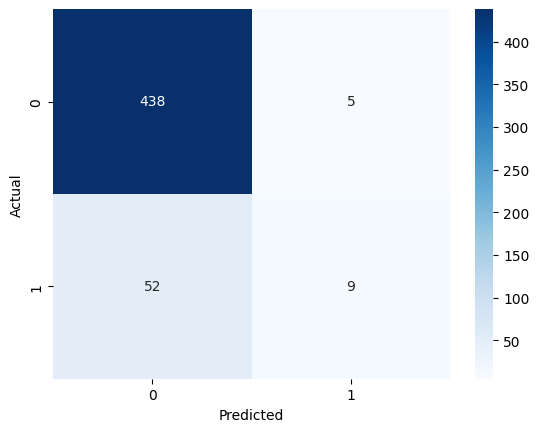

ROC-AUC: 0.7415534914702291


In [447]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

**Scaled Logistic Regression Baseline**

In [448]:
# Features to exclude
exclude_features = ['patientunitstayid', 'hospitalid', 'region', 'unittype', 'admitsource']

# Split features and target
X = df_scaled.drop(columns=exclude_features + ['bad_outcome'])
y = df_scaled['bad_outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize logistic regression with more iterations
model = LogisticRegression()  # Scaled data, no class weight

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

Accuracy: 0.8829365079365079

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94       443
           1       0.56      0.15      0.23        61

    accuracy                           0.88       504
   macro avg       0.73      0.57      0.59       504
weighted avg       0.85      0.88      0.85       504

Confusion Matrix:
 [[436   7]
 [ 52   9]]


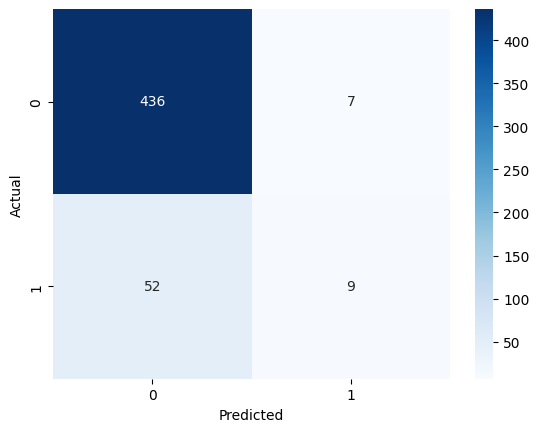

ROC-AUC: 0.7826296118121601


In [449]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

These are not class_weight="balanced". From a logistic regression baseline, our **scaled data will perform better**. We will keep both just in case! This may be a different case for other models such as random forests, which work fine with unscaled data. Out of curiosity, I want to see the feature importance.

In [451]:
# Get feature names
feature_names = X_train.columns

# Get coefficients
coefficients = model.coef_[0]  # For binary classification

# Combine into a DataFrame for easy viewing
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)})

# Sort by absolute value to see the most important features
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

print(feature_importance)

                       feature  coefficient  abs_coefficient
26             electivesurgery    -0.851458         0.851458
27                    activetx     0.812877         0.812877
24                   cirrhosis    -0.600878         0.600878
46   ethnicity_Native_American    -0.579943         0.579943
20                    lymphoma     0.556422         0.556422
21            metastaticcancer     0.554584         0.554584
28                    ventday1     0.418777         0.418777
43             ethnicity_Asian     0.416118         0.416118
19              hepaticfailure     0.388920         0.388920
0                          age     0.378954         0.378954
5                     dialysis    -0.348920         0.348920
3                  apachescore     0.336309         0.336309
41              gender_Unknown     0.293266         0.293266
25                    diabetes    -0.268629         0.268629
39               gender_Female    -0.248486         0.248486
45          ethnicity_Hi

From this we see that some of our ethnicities actually contribute to the model. This may be misleading due to the imbalance (the majority class for ethnicity are Caucasians). Next we have active treatment and then the comorbidities. We also see gender unknown up there so I might go ahead and fill that with the mode of the group (WE WILLS SEE, GET OPINION) and combine that. Age is also up there. Nettotal (I/O) of patient is actually not contributing as much as I thought it would.

## **Part 6: Feature Engineering**

- I want to combine minority ethnicities
    - The dominating class is Caucasian and I think that can skew the model towards them
- Change Unknown gender to mode (I think there are only 4 missing anyways)
    - There are about 1.5k males and 1k females
- Don't do a lot because I already made missingness flag variables, the features here capture each other well and relate to each other (pH can indicate low or high oxygen/respiration levels as an example), and there are already engineered features such as mean of respiration or standard deviation of heartrate
    - I want to avoid overfitting on this data, especially because this data is already pretty small with 2,520 cases

In [ ]:
# I did the feature engineering back in Part 4 with the data cleaning and preprocessing and made comments where the feature engineering happened!
# Also commented out the old code that the feature engineered features did not need anymore

## **Part 7: Reference Baseline After Feature Engineering**
### **CHECKPOINT 3 - Load from here**

**REMEMBER DO NOT INCLUDE IN MODEL:**
- patientunitstayid
- hospitalid
- region
- unittype
- admitsource

Again, class weight is NOT balanced! Just like we did for the very first baseline.

In [134]:
df_unscaled = pd.read_csv("df_unscaled.csv")
df_scaled = pd.read_csv("df_scaled.csv")

**Unscaled Logistic Regression Baseline After Feature Engineering**

In [135]:
# Features to exclude
exclude_features = ['patientunitstayid', 'hospitalid', 'region', 'unittype', 'admitsource']
X = df_unscaled.drop(columns=exclude_features + ['bad_outcome'])
y = df_unscaled['bad_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)  # Increase iterations, and also no class_weight specified

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

C:\Users\Marielle\anaconda3\envs\tf_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8829365079365079

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       443
           1       0.57      0.13      0.21        61

    accuracy                           0.88       504
   macro avg       0.73      0.56      0.58       504
weighted avg       0.85      0.88      0.85       504



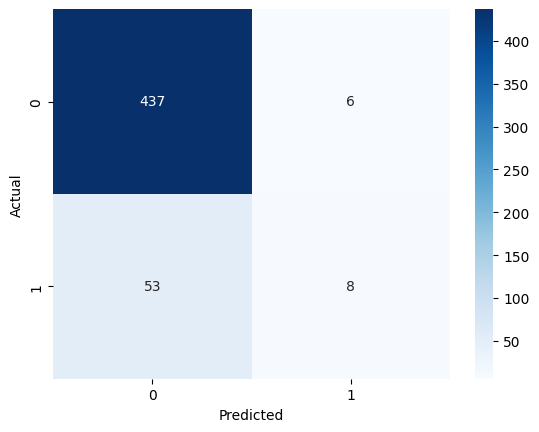

ROC-AUC: 0.7385190393368612


In [136]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

**Scaled Logistic Regression Baseline After Feature Engineering**

In [137]:
# Features to exclude
exclude_features = ['patientunitstayid', 'hospitalid', 'region', 'unittype', 'admitsource']
X = df_scaled.drop(columns=exclude_features + ['bad_outcome'])
y = df_scaled['bad_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()  # Scaled data, no class weight
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

Accuracy: 0.8829365079365079

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94       443
           1       0.56      0.15      0.23        61

    accuracy                           0.88       504
   macro avg       0.73      0.57      0.59       504
weighted avg       0.85      0.88      0.85       504

Confusion Matrix:
 [[436   7]
 [ 52   9]]


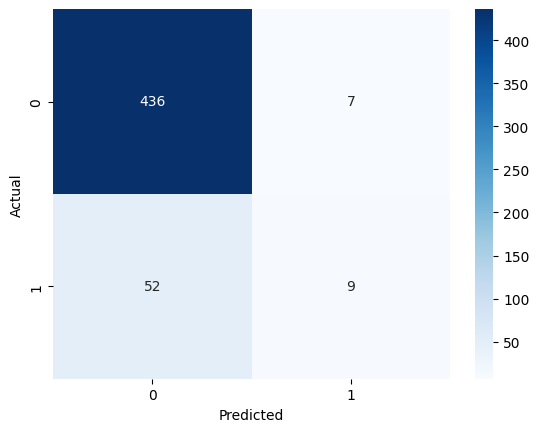

ROC-AUC: 0.7840358213373794


In [138]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

**Do we keep the engineered features?**

After feature engineering, the unscaled data did just the tiniest bit bad but the scaled data ROC AUC increased by a little and then the matrix stayed the same. **We will keep the engineered features.** Any improvement in ROC-AUC, even a small one, means the new features contain signal. Combining tiny minority groups into a single “Minority/Other” class reduces noise, avoids overfitting to extremely small groups. aligns with real-world ICU modeling practice where ethnicity often behaves like a broad covariate, not a fine-grained predictor.

## **Part 8: Handling Class Imbalance (Core Research Component)**

From this moment on, we will have 2 scenarios that will act as the core research component for this project regarding class imbalance for this ICU dataset:
- **Scenario 1:** Real life distribution (unbalanced)
- **Scenario 2:** Balanced distribution
  
For each scenario, we will build a stacked model because a stacked model can combine the strengths of multiple algorithms, it captures complex patterns in ICU data and improves prediction accuracy with limited 24-hour information.

Each scenario model will contain 2 base models and a meta learner model:
- **Model 1** --> Logistic regression (linear, scaled)
- **Model 2** --> XGBoost (tree-based nonlinear, unscaled)
- **Meta-learner:** Logistic regression (simple, reduces overfitting)

Only 2 is chosen because this dataset only has 2520 rows and we want to avoid making an overpowerered model that overfits the data. 

During training, **each model training will undergo stratified cross-validation** because it ensures each fold preserves the outcome’s class imbalance, producing stable and unbiased training for both base models and the meta-model. Metrics to focus on will be Recall > Precision > F1 and then ROC AUC/PR AUC in general. PR AUC is sensitive to minority class detection.

So the flow for the remaining pipeline for each scenario will be: **Base Models → Stacked Models → Testing → Final Comparison**

**DO NOT FORGET TO EXCLUDE FEATURES: patientunitstayid, hospitalid, region, unittype, admitsource**

## **Part 9: Training Base Models for Unbalanced Dataset**
### **CHECKPOINT 4 - Load from here**

In [251]:
df_unscaled = pd.read_csv("df_unscaled.csv")
df_scaled = pd.read_csv("df_scaled.csv")

**Prepare X, y, scaled, and unscaled versions and stratified CV**

In [252]:
exclude_features = ['patientunitstayid', 'hospitalid', 'region', 'unittype', 'admitsource']

# Prepare X and y
X_scaled = df_scaled.drop(columns=["bad_outcome"] + exclude_features).values
X_unscaled = df_unscaled.drop(columns=["bad_outcome"] + exclude_features).values
y = df_unscaled["bad_outcome"].values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train-test split
X_train_scaled, X_test_scaled, X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
    X_scaled, X_unscaled, y, test_size=0.2, stratify=y, random_state=42)

**Train logistic regression (scaled)**

In [253]:
lr = LogisticRegression(
    class_weight=None,      # unbalanced scenario
    max_iter=500,
    solver='liblinear')

lr_metrics = {
    "roc_auc": [], "pr_auc": [], "recall": [], "precision": [], "f1": []}

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    lr = LogisticRegression(class_weight=None, max_iter=500, solver='liblinear')
    lr.fit(X_tr, y_tr)
    preds = lr.predict_proba(X_val)[:, 1]
    preds_binary = (preds >= 0.5).astype(int)

    lr_metrics["roc_auc"].append(roc_auc_score(y_val, preds))
    lr_metrics["pr_auc"].append(average_precision_score(y_val, preds))
    lr_metrics["recall"].append(recall_score(y_val, preds_binary))
    lr_metrics["precision"].append(precision_score(y_val, preds_binary, zero_division=0))
    lr_metrics["f1"].append(f1_score(y_val, preds_binary))

print("Logistic Regression (UNBALANCED)")
print("---------------------------------")
for k, v in lr_metrics.items():
    print(f"{k}: {np.mean(v):.4f} ± {np.std(v):.4f}")

Logistic Regression (UNBALANCED)
---------------------------------
roc_auc: 0.7396 ± 0.0343
pr_auc: 0.3524 ± 0.0501
recall: 0.1497 ± 0.0306
precision: 0.6035 ± 0.0513
f1: 0.2385 ± 0.0419


**Train XGBoost (unscaled)**

In [254]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    scale_pos_weight=1)  # UNBALANCED

xgb_metrics = {
    "roc_auc": [], "pr_auc": [], "recall": [], "precision": [], "f1": []}

for train_idx, val_idx in skf.split(X_train_unscaled, y_train):
    X_tr, X_val = X_train_unscaled[train_idx], X_train_unscaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    xgb = XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", scale_pos_weight=1)
    xgb.fit(X_tr, y_tr)
    preds = xgb.predict_proba(X_val)[:, 1]
    preds_binary = (preds >= 0.5).astype(int)

    xgb_metrics["roc_auc"].append(roc_auc_score(y_val, preds))
    xgb_metrics["pr_auc"].append(average_precision_score(y_val, preds))
    xgb_metrics["recall"].append(recall_score(y_val, preds_binary))
    xgb_metrics["precision"].append(precision_score(y_val, preds_binary, zero_division=0))
    xgb_metrics["f1"].append(f1_score(y_val, preds_binary))

print("XGBoost (UNBALANCED)")
print("---------------------------------")
for k, v in xgb_metrics.items():
    print(f"{k}: {np.mean(v):.4f} ± {np.std(v):.4f}")

XGBoost (UNBALANCED)
---------------------------------
roc_auc: 0.7321 ± 0.0494
pr_auc: 0.3455 ± 0.0818
recall: 0.1366 ± 0.0435
precision: 0.5413 ± 0.1522
f1: 0.2174 ± 0.0671


## **Part 10: Training Base Models for Balanced Dataset**

**Train logistic regression (scaled)**

In [255]:
lr_bal = LogisticRegression(
    class_weight='balanced',  # BALANCED scenario
    max_iter=500,
    solver='liblinear')

lr_metrics_bal = {"roc_auc": [], "pr_auc": [], "recall": [], "precision": [], "f1": []}

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    lr_bal = LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')
    lr_bal.fit(X_tr, y_tr)
    preds = lr_bal.predict_proba(X_val)[:, 1]
    preds_binary = (preds >= 0.5).astype(int)

    lr_metrics_bal["roc_auc"].append(roc_auc_score(y_val, preds))
    lr_metrics_bal["pr_auc"].append(average_precision_score(y_val, preds))
    lr_metrics_bal["recall"].append(recall_score(y_val, preds_binary))
    lr_metrics_bal["precision"].append(precision_score(y_val, preds_binary, zero_division=0))
    lr_metrics_bal["f1"].append(f1_score(y_val, preds_binary))

print("Logistic Regression (BALANCED)")
print("---------------------------------")
for k, v in lr_metrics_bal.items():
    print(f"{k}: {np.mean(v):.4f} ± {np.std(v):.4f}")

Logistic Regression (BALANCED)
---------------------------------
roc_auc: 0.7321 ± 0.0367
pr_auc: 0.3409 ± 0.0548
recall: 0.6320 ± 0.0683
precision: 0.2431 ± 0.0213
f1: 0.3510 ± 0.0319


**Train XGBoost (unscaled)**

In [256]:
# compute scale_pos_weight for training set
n_pos = sum(y_train)
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos

xgb_bal = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,  # BALANCED scenario
    random_state=42)

xgb_metrics_bal = {"roc_auc": [], "pr_auc": [], "recall": [], "precision": [], "f1": []}

for train_idx, val_idx in skf.split(X_train_unscaled, y_train):
    X_tr, X_val = X_train_unscaled[train_idx], X_train_unscaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    xgb_bal = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )
    xgb_bal.fit(X_tr, y_tr)
    preds = xgb_bal.predict_proba(X_val)[:, 1]
    preds_binary = (preds >= 0.5).astype(int)

    xgb_metrics_bal["roc_auc"].append(roc_auc_score(y_val, preds))
    xgb_metrics_bal["pr_auc"].append(average_precision_score(y_val, preds))
    xgb_metrics_bal["recall"].append(recall_score(y_val, preds_binary))
    xgb_metrics_bal["precision"].append(precision_score(y_val, preds_binary, zero_division=0))
    xgb_metrics_bal["f1"].append(f1_score(y_val, preds_binary))

print("XGBoost (BALANCED)")
print("---------------------------------")
for k, v in xgb_metrics_bal.items():
    print(f"{k}: {np.mean(v):.4f} ± {np.std(v):.4f}")

XGBoost (BALANCED)
---------------------------------
roc_auc: 0.7231 ± 0.0377
pr_auc: 0.3309 ± 0.0595
recall: 0.3377 ± 0.0630
precision: 0.3579 ± 0.0795
f1: 0.3467 ± 0.0687


## **Part 11: Building Stacked Model for Unbalanced Dataset**

**Generate out-of-fold predictions from base models**

In [257]:
# Arrays to store base model predictions for meta learner
oof_lr = np.zeros_like(y_train, dtype=float)
oof_xgb = np.zeros_like(y_train, dtype=float)

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    # Logistic Regression (scaled)
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    lr = LogisticRegression(max_iter=500, solver='liblinear')
    lr.fit(X_tr, y_tr)
    oof_lr[val_idx] = lr.predict_proba(X_val)[:, 1]

    # XGBoost (unscaled)
    X_tr_xgb, X_val_xgb = X_train_unscaled[train_idx], X_train_unscaled[val_idx]
    xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4,
                        subsample=0.9, colsample_bytree=0.9, eval_metric="logloss",
                        scale_pos_weight=1)
    xgb.fit(X_tr_xgb, y_tr)
    oof_xgb[val_idx] = xgb.predict_proba(X_val_xgb)[:, 1]

**Train meta-learner (logistic regression)**

In [258]:
# Stack base model predictions as features
X_meta_train = np.vstack([oof_lr, oof_xgb]).T

# Train meta-learner once
meta_lr = LogisticRegression(max_iter=500, solver='liblinear')
meta_lr.fit(X_meta_train, y_train)

# Predict on training set
preds = meta_lr.predict_proba(X_meta_train)[:, 1]
preds_binary = (preds >= 0.5).astype(int)  # use your previously optimized threshold

# Compute training metrics
meta_metrics = {
    "roc_auc": roc_auc_score(y_train, preds),
    "pr_auc": average_precision_score(y_train, preds),
    "recall": recall_score(y_train, preds_binary),
    "precision": precision_score(y_train, preds_binary, zero_division=0),
    "f1": f1_score(y_train, preds_binary)}

print("Stacked Model (Unbalanced) — Training Metrics")
print("---------------------------------")
for k, v in meta_metrics.items():
    print(f"{k}: {v:.4f}")

Stacked Model (Unbalanced) — Training Metrics
---------------------------------
roc_auc: 0.7476
pr_auc: 0.3632
recall: 0.1282
precision: 0.6667
f1: 0.2151


**Find optimal threshold that prioritizes recall - just curious! We will use default 0.5**

In [259]:
# Define thresholds to try
thresholds = np.arange(0.0, 1.01, 0.01)

best_thresh = 0.5
best_recall = 0
best_precision = 0
best_f1 = 0

for t in thresholds:
    preds_binary = (preds >= t).astype(int)
    rec = recall_score(y_train, preds_binary)   # <-- use y_train
    prec = precision_score(y_train, preds_binary, zero_division=0)
    f1 = f1_score(y_train, preds_binary)

    # Choose threshold that maximizes recall while keeping precision reasonable
    if rec > best_recall and prec >= 0.2:  # adjust 0.2 as minimum acceptable precision
        best_thresh = t
        best_recall = rec
        best_precision = prec
        best_f1 = f1

print(f"Optimized threshold: {best_thresh:.2f}")
print(f"Recall: {best_recall:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"F1 Score: {best_f1:.4f}")

Optimized threshold: 0.09
Recall: 0.7308
Precision: 0.2109
F1 Score: 0.3273


By optimizing recall, we are catching ~73% of patients who will have the adverse outcome. Only ~21% of patients flagged actually have the outcome. Low, but that’s expected when you push recall so high. Clinically, this may mean more false alarms, but better to over-predict than under-predict in ICU. That also explains why F1 is low.

## **Part 12: Building Stacked Model for Balanced Dataset**

**Prepare**

In [260]:
# Compute scale_pos_weight for XGBoost (balanced)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

**Generate out-of-fold predictions from base models**

In [261]:
# Arrays to store base model predictions for meta learner
oof_lr_bal = np.zeros_like(y_train, dtype=float)
oof_xgb_bal = np.zeros_like(y_train, dtype=float)

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    # Logistic Regression (scaled, balanced)
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    lr_bal = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced')
    lr_bal.fit(X_tr, y_tr)
    oof_lr_bal[val_idx] = lr_bal.predict_proba(X_val)[:, 1]

    # XGBoost (unscaled, balanced)
    X_tr_xgb, X_val_xgb = X_train_unscaled[train_idx], X_train_unscaled[val_idx]
    xgb_bal = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight)
    xgb_bal.fit(X_tr_xgb, y_tr)
    oof_xgb_bal[val_idx] = xgb_bal.predict_proba(X_val_xgb)[:, 1]

**Train meta-learner (logistic regression)**

In [262]:
# Train meta-learner (logistic regression) on training stacked features
X_meta_train = np.vstack([oof_lr_bal, oof_xgb_bal]).T

meta_lr_bal = LogisticRegression(max_iter=500, solver='liblinear')
meta_lr_bal.fit(X_meta_train, y_train)

# Get predicted probabilities on training set (for metrics if you want)
preds = meta_lr_bal.predict_proba(X_meta_train)[:, 1]
preds_binary = (preds >= 0.5).astype(int)  # use a placeholder threshold

# Compute metrics on training set
meta_metrics_bal = {
    "roc_auc": roc_auc_score(y_train, preds),
    "pr_auc": average_precision_score(y_train, preds),
    "recall": recall_score(y_train, preds_binary),
    "precision": precision_score(y_train, preds_binary, zero_division=0),
    "f1": f1_score(y_train, preds_binary)
}

print("Stacked Model (BALANCED)")
print("---------------------------------")
for k, v in meta_metrics_bal.items():
    print(f"{k}: {v:.4f}")

Stacked Model (BALANCED)
---------------------------------
roc_auc: 0.7402
pr_auc: 0.3550
recall: 0.0641
precision: 0.8824
f1: 0.1195


**Find optimal threshold that prioritizes recall - just curious! We will use default 0.5**

In [263]:
# Get predicted probabilities on training set
y_pred_probs = meta_lr_bal.predict_proba(X_meta_train)[:, 1]

# Try thresholds from 0.01 to 0.99
thresholds = np.arange(0.01, 1.0, 0.01)
min_precision = 0.2  # same as the unbalanced stacked model
best_recall = 0
best_threshold = 0.5

for t in thresholds:
    y_pred_binary = (y_pred_probs >= t).astype(int)
    r = recall_score(y_train, y_pred_binary)    # <-- use y_train
    p = precision_score(y_train, y_pred_binary, zero_division=0)
    if r > best_recall and p >= min_precision:
        best_recall = r
        best_threshold = t

# Compute metrics at best threshold
y_pred_binary = (y_pred_probs >= best_threshold).astype(int)
recall = recall_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

print("Balanced Stacked Model Threshold Optimization")
print("---------------------------------")
print(f"Optimized threshold: {best_threshold:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Balanced Stacked Model Threshold Optimization
---------------------------------
Optimized threshold: 0.10
Recall: 0.7051
Precision: 0.2045
F1 Score: 0.3170


## **Part 13: Testing Unbalanced and Balanced Stacked Models**

In [264]:
# Prepare stacked features for test set
# Unbalanced stacked model
X_meta_test_unbal = np.vstack([
    lr.predict_proba(X_test_scaled)[:, 1],       # base LR (scaled)
    xgb.predict_proba(X_test_unscaled)[:, 1]]).T    # base XGB (unscaled)]

# Balanced stacked model
X_meta_test_bal = np.vstack([
    lr_bal.predict_proba(X_test_scaled)[:, 1],  # base LR (scaled, balanced)
    xgb_bal.predict_proba(X_test_unscaled)[:, 1]]).T # base XGB (unscaled, balanced)

# Predict with meta-learners
# Unbalanced meta-learner
y_pred_probs_unbal = meta_lr.predict_proba(X_meta_test_unbal)[:, 1]
y_pred_unbal = (y_pred_probs_unbal >= 0.5).astype(int)  # manually set threshold

# Balanced meta-learner
y_pred_probs_bal = meta_lr_bal.predict_proba(X_meta_test_bal)[:, 1]
y_pred_bal = (y_pred_probs_bal >= 0.5).astype(int)       # manually set threshold

# Compute test metrics
def compute_metrics(y_true, y_pred, y_prob):
    return {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        "recall": recall_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred)}

metrics_unbal = compute_metrics(y_test, y_pred_unbal, y_pred_probs_unbal)
metrics_bal = compute_metrics(y_test, y_pred_bal, y_pred_probs_bal)

# Results
print("Test Metrics - Unbalanced Stacked Model")
print("----------------------------------------")
for k, v in metrics_unbal.items():
    print(f"{k}: {v:.4f}")

print("\nTest Metrics - Balanced Stacked Model")
print("----------------------------------------")
for k, v in metrics_bal.items():
    print(f"{k}: {v:.4f}")

Test Metrics - Unbalanced Stacked Model
----------------------------------------
roc_auc: 0.8393
pr_auc: 0.4375
recall: 0.1017
precision: 0.6667
f1: 0.1765

Test Metrics - Balanced Stacked Model
----------------------------------------
roc_auc: 0.8421
pr_auc: 0.4376
recall: 0.0678
precision: 1.0000
f1: 0.1270


## **Part 14: Final Evaluation and Model Comparison with Feature Importance**

**Classification report comparison**

In [265]:
# Function for classification report as a real DataFrame
def classification_report_df(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    return report_df.round(3)

report_unbal = classification_report_df(y_test, y_pred_unbal)
report_bal = classification_report_df(y_test, y_pred_bal)

# Display classification reports with titles
print("=== Real-Life Class Distribution (Unbalanced) ===")
print("=== Threshold: 0.09 ===")
display(report_unbal)

print("\n=== Balanced Class Distribution ===")
print("=== Threshold: 0.1 ===")
display(report_bal)

=== Real-Life Class Distribution (Unbalanced) ===
=== Threshold: 0.09 ===


,precision,recall,f1-score,support
0,0.893,0.993,0.940,445.000
1,0.667,0.102,0.176,59.000
accuracy,0.889,0.889,0.889,0.889
macro avg,0.780,0.547,0.558,504.000
weighted avg,0.866,0.889,0.851,504.000



=== Balanced Class Distribution ===
=== Threshold: 0.1 ===


,precision,recall,f1-score,support
0,0.890,1.000,0.942,445.000
1,1.000,0.068,0.127,59.000
accuracy,0.891,0.891,0.891,0.891
macro avg,0.945,0.534,0.534,504.000
weighted avg,0.903,0.891,0.846,504.000


**Confusion matrix comparisons**

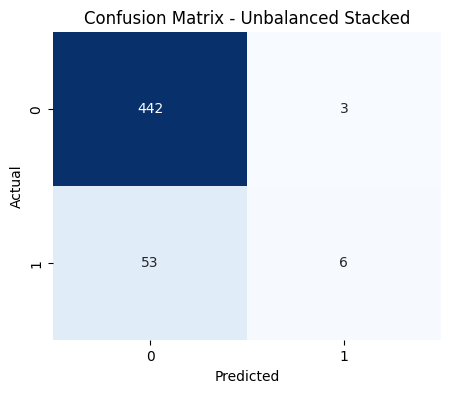

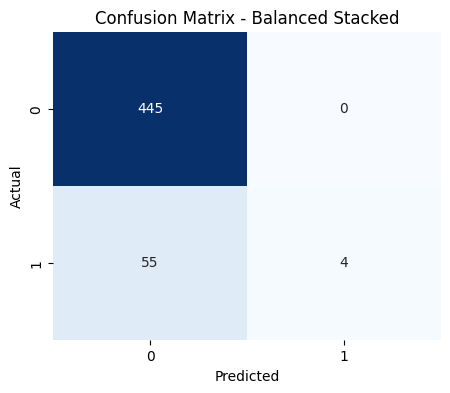

In [266]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="", labels=None, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if labels is None:
        labels = sorted(list(set(y_true)))
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()
    
    return cm_df  # optional if you want the DataFrame as well

# Plot confusion matrices for both models
cm_unbal = plot_confusion_matrix(y_test, y_pred_unbal, title="Confusion Matrix - Unbalanced Stacked")
cm_bal = plot_confusion_matrix(y_test, y_pred_bal, title="Confusion Matrix - Balanced Stacked")


**ROC and PR-AUC Curves**

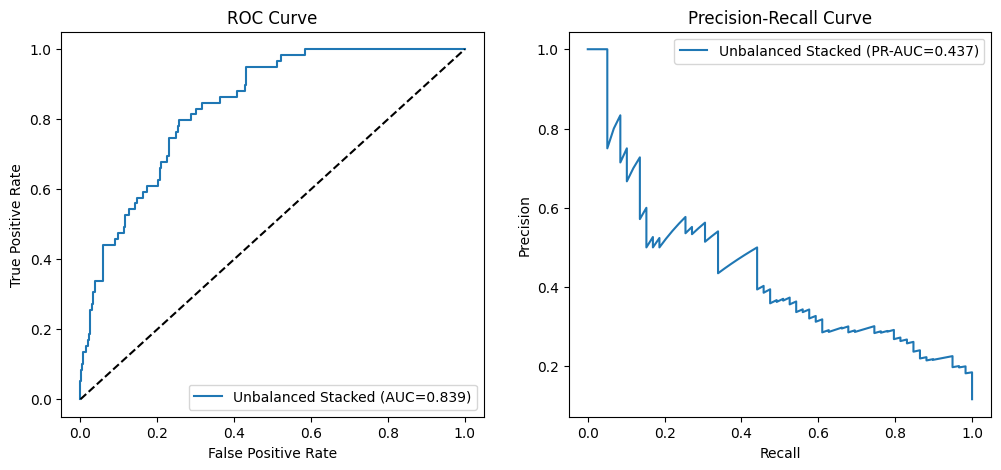

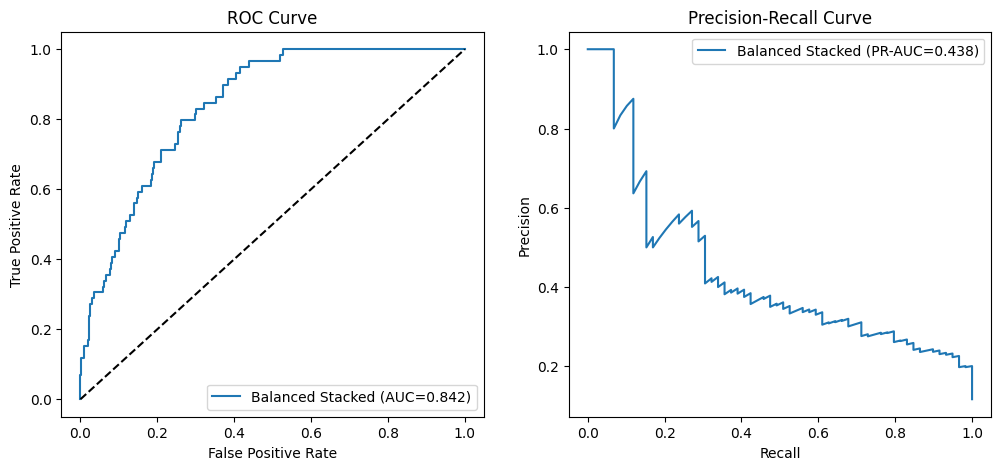

In [267]:
def plot_curves(y_true, y_probs, label):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = average_precision_score(y_true, y_probs)

    # Plot ROC
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Plot PR
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"{label} (PR-AUC={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.show()

# Plot for unbalanced
plot_curves(y_test, y_pred_probs_unbal, "Unbalanced Stacked")

# Plot for balanced
plot_curves(y_test, y_pred_probs_bal, "Balanced Stacked")

**Barplot comparisons of metrics**

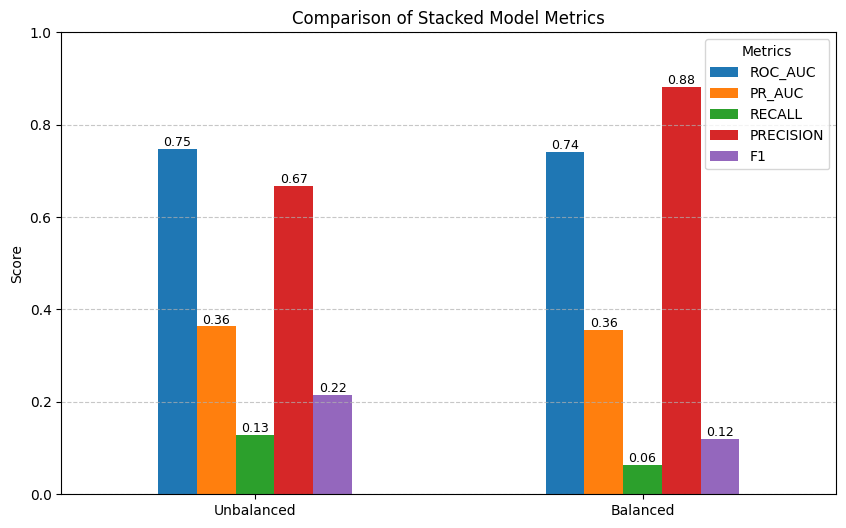

In [268]:
# Example metric averages for demonstration
metrics_unbal = {
    "roc_auc": np.mean(meta_metrics["roc_auc"]),
    "pr_auc": np.mean(meta_metrics["pr_auc"]),
    "recall": np.mean(meta_metrics["recall"]),
    "precision": np.mean(meta_metrics["precision"]),
    "f1": np.mean(meta_metrics["f1"])}

metrics_bal = {
    "roc_auc": np.mean(meta_metrics_bal["roc_auc"]),
    "pr_auc": np.mean(meta_metrics_bal["pr_auc"]),
    "recall": np.mean(meta_metrics_bal["recall"]),
    "precision": np.mean(meta_metrics_bal["precision"]),
    "f1": np.mean(meta_metrics_bal["f1"])}

# Convert to DataFrame for easier plotting
df_metrics = pd.DataFrame([metrics_unbal, metrics_bal], index=["Unbalanced", "Balanced"])

# Capitalize metric names
df_metrics.columns = [col.upper() for col in df_metrics.columns]

# Plot with annotations
ax = df_metrics.plot(kind="bar", figsize=(10,6))
plt.title("Comparison of Stacked Model Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=9)
plt.show()

## **Part 15: ICU Simulation**

In [269]:
# Example: select 10 patients randomly with balanced 0 and 1
np.random.seed(42) # Choose random seed

# Get indices for each class
idx_0 = np.where(y_test == 0)[0]
idx_1 = np.where(y_test == 1)[0]

# Sample 5 from each to balance
sample_idx = np.concatenate([
    np.random.choice(idx_0, size=5, replace=False),
    np.random.choice(idx_1, size=5, replace=False)
])

# Unbalanced model
threshold_unbal = 0.08  # your optimized threshold
df_unbal_sim = pd.DataFrame({
    "Patient_ID": sample_idx,
    "Actual": y_test[sample_idx],
    "Pred_Class": (y_pred_unbal[sample_idx] >= threshold_unbal).astype(int)
})
df_unbal_sim["Correct"] = df_unbal_sim["Actual"] == df_unbal_sim["Pred_Class"]
display(df_unbal_sim)

,Patient_ID,Actual,Pred_Class,Correct
0,317,0,0,True
1,405,0,0,True
2,132,0,0,True
3,465,0,0,True
4,78,0,0,True
5,122,1,0,False
6,404,1,0,False
7,54,1,0,False
8,291,1,0,False
9,51,1,0,False


In [270]:
# Balanced model
threshold_bal = 0.20  # replace with your optimized threshold

# Sample 5 from each class (same as before)
np.random.seed(10) # Choose random seed
idx_0 = np.where(y_test == 0)[0]
idx_1 = np.where(y_test == 1)[0]
sample_idx = np.concatenate([
    np.random.choice(idx_0, size=5, replace=False),
    np.random.choice(idx_1, size=5, replace=False)])

df_bal_sim = pd.DataFrame({
    "Patient_ID": sample_idx,
    "Actual": y_test[sample_idx],
    "Pred_Class": (y_pred_bal[sample_idx] >= threshold_bal).astype(int)})
df_bal_sim["Correct"] = df_bal_sim["Actual"] == df_bal_sim["Pred_Class"]
display(df_bal_sim)

,Patient_ID,Actual,Pred_Class,Correct
0,416,0,0,True
1,237,0,0,True
2,270,0,0,True
3,259,0,0,True
4,239,0,0,True
5,342,1,0,False
6,468,1,0,False
7,353,1,0,False
8,37,1,0,False
9,104,1,0,False


We see that the stacked model did not perform as well as we wanted. It performed so well for precision due to the many good outcomes but we want to prioritize recall. The meta-learner is trained on out-of-fold predictions from the training set, so its performance depends on how well the base models complement each other and how much signal it can extract. There could have been redundant information, the threshold effect, small positive class, overfitting, etc. There are many reasons why it might have performed so much worse than just a single model in the recall department so will experiment next with individual models.

## **Part 16: Single Model Overview**

Continuing on, we will still have 2 scenarios that will act as the core research component for this project regarding class imbalance for this ICU dataset:
- **Scenario 1:** Real life distribution (unbalanced)
- **Scenario 2:** Balanced distribution
  
For each scenario, we will test several single models by training them then testing. We will not do any neural networks because our dataset is only 2520 rows. NN's shine the best with large datasets but using a NN on a small dataset has the high risk of overfitting because it is so powerful. 

Each scenario model will contain these base models and these models are chosen based on our small dataset and what medical professionals have used and trust:
- **Model 1** --> Logistic regression (linear, scaled)
- **Model 2** --> XGBoost (tree-based nonlinear, unscaled)
- **Model 3** --> Random Forest (nonlinear, unscaled)
- **Model 4** --> LightGBM (used commonly in medical ML)
- **Model 5:** --> SVM (kernel-based nonlinear, scaled)
- **Model 6:** --> Stacked model from previous section for comparison (LR + XGBoost base models and LR meta-learner)

During training, **each model training will undergo stratified cross-validation** because it ensures each fold preserves the outcome’s class imbalance, producing stable and unbiased training for both base models and the meta-model. Metrics to focus on will be Recall > Precision > F1 and then ROC AUC/PR AUC in general. PR AUC is sensitive to minority class detection.

So the flow for the remaining pipeline for each scenario will be: **Training Base Models → Testing → Final Comparison**

**DO NOT FORGET TO EXCLUDE FEATURES: patientunitstayid, hospitalid, region, unittype, admitsource**

## **Part 17: Training and Testing Individual Models for Unbalanced Dataset**
### **CHECKPOINT 5 - Load from here**

In [199]:
df_unscaled = pd.read_csv("df_unscaled.csv")
df_scaled = pd.read_csv("df_scaled.csv")

**Prepare data**

In [200]:
exclude_features = ['patientunitstayid', 'hospitalid', 'region', 'unittype', 'admitsource']
X_scaled = df_scaled.drop(columns=["bad_outcome"] + exclude_features)
X_unscaled = df_unscaled.drop(columns=["bad_outcome"] + exclude_features)
y = df_unscaled["bad_outcome"]  # use unscaled for consistent target

# For scaled, 80-20 train-test split
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# For unscaled, 80-20 train-test split
X_train_unscaled, X_test_unscaled, _, _ = train_test_split(
    X_unscaled, y, test_size=0.2, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Model 1: Logistic regression testing and training**

In [201]:
# Initialize Model
log_reg = LogisticRegression(max_iter=500, random_state=42)

# Stratified 5-Fold CV on Training Set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# CV predictions (for metrics)
# y_pred_cv = cross_val_predict(
    # log_reg,
    # X_train_scaled,
    # y_train,
    # cv=skf,
    # method='predict')

# y_prob_cv = cross_val_predict(
    # log_reg,
    # X_train_scaled,
    # y_train,
    # cv=skf,
    # method='predict_proba')[:, 1]

# cv_results = {
    # "Model": "Logistic Regression",
    # "CV_Recall": recall_score(y_train, y_pred_cv),
    # "CV_Precision": precision_score(y_train, y_pred_cv),
    # "CV_F1": f1_score(y_train, y_pred_cv),
    # "CV_ROC_AUC": roc_auc_score(y_train, y_prob_cv),
    # "CV_PR_AUC": average_precision_score(y_train, y_prob_cv)}

# print("Cross-Validation Results:")
# display(pd.DataFrame([cv_results]))

# Final Training on Full Train Set
log_reg.fit(X_train_scaled, y_train)

# Test Set Evaluation
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

logreg_results = {
    "Model": "Logistic Regression",
    "Recall": recall_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "F1": f1_score(y_test, y_pred_log),
    "ROC_AUC": roc_auc_score(y_test, y_prob_log),
    "PR_AUC": average_precision_score(y_test, y_prob_log)}
print("Test Set Results:")
display(pd.DataFrame([logreg_results]))

Test Set Results:


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,Logistic Regression,0.118644,0.636364,0.2,0.851571,0.445139


**Model 2: XGBoost testing and training**

In [202]:
# Stratified CV on Training Data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss")

# ROC-AUC with cross-validation
xgb_cv_scores = cross_val_score(
    xgb_model, 
    X_train_unscaled, 
    y_train, 
    cv=skf, 
    scoring="roc_auc")

print("XGBoost (Unbalanced) CV ROC-AUC Mean:", xgb_cv_scores.mean())
print("XGBoost (Unbalanced) CV ROC-AUC Std:", xgb_cv_scores.std())

# Fit on full training set
xgb_model.fit(X_train_unscaled, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_unscaled)              # threshold = 0.5
y_prob_xgb = xgb_model.predict_proba(X_test_unscaled)[:, 1]  # probabilities

# Metrics
xgb_results = {
    "Model": "XGBoost",
    "Recall": recall_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "ROC_AUC": roc_auc_score(y_test, y_prob_xgb),
    "PR_AUC": average_precision_score(y_test, y_prob_xgb)}

print("Test Set Results:")
pd.DataFrame([xgb_results])

XGBoost (Unbalanced) CV ROC-AUC Mean: 0.7275978624151384
XGBoost (Unbalanced) CV ROC-AUC Std: 0.04366839259644915
Test Set Results:


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,XGBoost,0.186441,0.578947,0.282051,0.782784,0.393437


**Model 3: Random Forest testing and training**

In [203]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1)


# 5-fold stratified CV — see recall score
rf_cv_scores = cross_val_score(
    rf_model,
    X_train_unscaled,
    y_train,
    cv=skf,
    scoring="recall")

print("Random Forest CV Recall Scores:", rf_cv_scores)
print("Mean RF CV Recall Score:", rf_cv_scores.mean())

rf_model.fit(X_train_unscaled, y_train)
y_pred_rf = rf_model.predict(X_test_unscaled)
y_prob_rf = rf_model.predict_proba(X_test_unscaled)[:, 1]

rf_results = {
    "Model": "Random Forest",
    "Recall": recall_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC_AUC": roc_auc_score(y_test, y_prob_rf),
    "PR_AUC": average_precision_score(y_test, y_prob_rf)}

print("Test Set Results:")
pd.DataFrame([rf_results])

Random Forest CV Recall Scores: [0.14893617 0.13043478 0.14893617 0.08510638 0.08510638]
Mean RF CV Recall Score: 0.11970397779833489
Test Set Results:


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,Random Forest,0.084746,0.714286,0.151515,0.808589,0.443261


**Model 4: LightGBM training and testing**

In [204]:
lgb_model = LGBMClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.03,
    num_leaves=31, verbosity=-1)

lgb_cv_scores = cross_val_score(
    lgb_model,
    X_train_unscaled,
    y_train,
    cv=skf,
    scoring="roc_auc")

print("LightGBM CV ROC-AUC Scores:", lgb_cv_scores)
print("Mean LightGBM CV ROC-AUC:", lgb_cv_scores.mean())

lgb_model.fit(X_train_unscaled, y_train)
y_pred_lgb = lgb_model.predict(X_test_unscaled)
y_prob_lgb = lgb_model.predict_proba(X_test_unscaled)[:, 1]

lgb_results = {
    "Model": "LightGBM",
    "Recall": recall_score(y_test, y_pred_lgb),
    "Precision": precision_score(y_test, y_pred_lgb),
    "F1": f1_score(y_test, y_pred_lgb),
    "ROC_AUC": roc_auc_score(y_test, y_prob_lgb),
    "PR_AUC": average_precision_score(y_test, y_prob_lgb)}
print("Test Set Results:")
pd.DataFrame([lgb_results])

LightGBM CV ROC-AUC Scores: [0.77167888 0.71148459 0.73732967 0.76207268 0.66130767]
Mean LightGBM CV ROC-AUC: 0.7287746989783243
Test Set Results:


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,LightGBM,0.169492,0.714286,0.273973,0.810474,0.44537


**Model 5: SVM training and testing**

In [205]:
svm_model = SVC(
    kernel="rbf",
    probability=True,   # enables predict_proba
    random_state=42)

svm_cv_scores = cross_val_score(
    svm_model,
    X_train_scaled,
    y_train,
    cv=skf,
    scoring="roc_auc")

print("SVM CV ROC-AUC Scores:", svm_cv_scores)
print("Mean SVM CV ROC-AUC:", svm_cv_scores.mean())

svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_results = {
    "Model": "SVM",
    "Recall": recall_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm),
    "F1": f1_score(y_test, y_pred_svm),
    "ROC_AUC": roc_auc_score(y_test, y_prob_svm),
    "PR_AUC": average_precision_score(y_test, y_prob_svm)}
print("Test Set Results:")
pd.DataFrame([svm_results])

SVM CV ROC-AUC Scores: [0.78067823 0.65868956 0.68413818 0.729082   0.63764045]
Mean SVM CV ROC-AUC: 0.6980456835729335
Test Set Results:


C:\Users\Marielle\anaconda3\envs\tf_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,SVM,0.0,0.0,0.0,0.752961,0.372165


So there are zeros. SVM failed to predict any positives, which shows limitation of SVM on small, imbalanced datasets. ROC-AUC and PR-AUC are still meaningful because they consider probability outputs, not hard predictions. This is actually a useful finding because:
- Trees (RF, XGB, LGBM) can handle imbalance better
- Linear/kernel models may struggle

**Model 6: Stacked model**

In [206]:
# Define Base Learners
base_learners = [
    ('lr', LogisticRegression(max_iter=500, random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))]

# Define Meta-Learner
meta_learner = LogisticRegression(max_iter=500, random_state=42)

# Define Stacking Classifier
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=skf,               # Stratified CV for stacking
    stack_method='predict_proba',  # feed probabilities to meta-learner
    n_jobs=-1)

# Stratified CV on Training Set
stack_cv_scores = cross_val_score(
    stack_model,
    X_train_scaled,   # Use scaled data for LR + XGB works fine
    y_train,
    cv=skf,
    scoring='roc_auc')

print("Stacked Model CV ROC-AUC Scores:", stack_cv_scores)
print("Mean Stacked CV ROC-AUC:", stack_cv_scores.mean())

# Fit on Full Training Set
stack_model.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred_stacked = stack_model.predict(X_test_scaled)
y_prob_stacked = stack_model.predict_proba(X_test_scaled)[:, 1]

# Collect Test-Set Metrics
stack_results = {
    "Model": "Stacked Model",
    "Recall": recall_score(y_test, y_pred_stacked),
    "Precision": precision_score(y_test, y_pred_stacked),
    "F1": f1_score(y_test, y_pred_stacked),
    "ROC_AUC": roc_auc_score(y_test, y_prob_stacked),
    "PR_AUC": average_precision_score(y_test, y_prob_stacked)}
print("Test Set Results:")
pd.DataFrame([stack_results])

Stacked Model CV ROC-AUC Scores: [0.77787711 0.71032761 0.76392541 0.77462348 0.69453741]
Mean Stacked CV ROC-AUC: 0.7442582038584123
Test Set Results:


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,Stacked Model,0.101695,0.857143,0.181818,0.846886,0.45532


## **Part 18: Training and Testing Individual Models for Balanced Dataset**

**Model 1: Logistic regression testing and training**

In [207]:
# Initialize Model (Balanced)
log_reg_bal = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)

# Stratified 5-Fold CV on Training Set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Final Training on Full Train Set
log_reg_bal.fit(X_train_scaled, y_train)

# Test Set Evaluation
y_pred_log_bal = log_reg_bal.predict(X_test_scaled)
y_prob_log_bal = log_reg_bal.predict_proba(X_test_scaled)[:, 1]

# Metrics
logreg_results_bal = {
    "Model": "Logistic Regression",
    "Recall": recall_score(y_test, y_pred_log_bal),
    "Precision": precision_score(y_test, y_pred_log_bal),
    "F1": f1_score(y_test, y_pred_log_bal),
    "ROC_AUC": roc_auc_score(y_test, y_prob_log_bal),
    "PR_AUC": average_precision_score(y_test, y_prob_log_bal)}

print("Test Set Results (Balanced):")
display(pd.DataFrame([logreg_results_bal]))

Test Set Results (Balanced):


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,Logistic Regression,0.762712,0.294118,0.424528,0.842316,0.422831


**Model 2: XGBoost testing and training**

In [208]:
# Stratified CV on Training Data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute scale_pos_weight for balancing
scale_pos_weight_bal = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost (Balanced)
xgb_model_bal = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight_bal)

# ROC-AUC with cross-validation
xgb_cv_scores_bal = cross_val_score(
    xgb_model_bal, 
    X_train_unscaled, 
    y_train, 
    cv=skf, 
    scoring="roc_auc")

print("XGBoost (Balanced) CV ROC-AUC Mean:", xgb_cv_scores_bal.mean())
print("XGBoost (Balanced) CV ROC-AUC Std:", xgb_cv_scores_bal.std())

# Fit on full training set
xgb_model_bal.fit(X_train_unscaled, y_train)

# Predictions
y_pred_xgb_bal = xgb_model_bal.predict(X_test_unscaled)              # threshold = 0.5
y_prob_xgb_bal = xgb_model_bal.predict_proba(X_test_unscaled)[:, 1]  # probabilities

# Metrics
xgb_results_bal = {
    "Model": "XGBoost",
    "Recall": recall_score(y_test, y_pred_xgb_bal),
    "Precision": precision_score(y_test, y_pred_xgb_bal),
    "F1": f1_score(y_test, y_pred_xgb_bal),
    "ROC_AUC": roc_auc_score(y_test, y_prob_xgb_bal),
    "PR_AUC": average_precision_score(y_test, y_prob_xgb_bal)}

print("Test Set Results (Balanced):")
display(pd.DataFrame([xgb_results_bal]))

XGBoost (Balanced) CV ROC-AUC Mean: 0.7259378632181287
XGBoost (Balanced) CV ROC-AUC Std: 0.04698903457147943
Test Set Results (Balanced):


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,XGBoost,0.20339,0.48,0.285714,0.794934,0.386345


**Model 3: Random Forest testing and training**

In [209]:
# Stratified CV setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Random Forest (Balanced)
rf_model_bal = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced')

# 5-fold stratified CV — recall
rf_cv_scores_bal = cross_val_score(
    rf_model_bal,
    X_train_unscaled,
    y_train,
    cv=skf,
    scoring="recall")

print("Random Forest (Balanced) CV Recall Scores:", rf_cv_scores_bal)
print("Mean RF (Balanced) CV Recall Score:", rf_cv_scores_bal.mean())

# Fit on full training set
rf_model_bal.fit(X_train_unscaled, y_train)

# Predictions
y_pred_rf_bal = rf_model_bal.predict(X_test_unscaled)
y_prob_rf_bal = rf_model_bal.predict_proba(X_test_unscaled)[:, 1]

# Metrics
rf_results_bal = {
    "Model": "Random Forest",
    "Recall": recall_score(y_test, y_pred_rf_bal),
    "Precision": precision_score(y_test, y_pred_rf_bal),
    "F1": f1_score(y_test, y_pred_rf_bal),
    "ROC_AUC": roc_auc_score(y_test, y_prob_rf_bal),
    "PR_AUC": average_precision_score(y_test, y_prob_rf_bal)}
print("Test Set Results (Balanced):")
display(pd.DataFrame([rf_results_bal]))

Random Forest (Balanced) CV Recall Scores: [0.0212766  0.         0.0212766  0.         0.04255319]
Mean RF (Balanced) CV Recall Score: 0.01702127659574468
Test Set Results (Balanced):


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,Random Forest,0.033898,0.666667,0.064516,0.816302,0.383567


**Model 4: LightGBM training and testing**

In [210]:
# Stratified CV setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute scale_pos_weight for balancing
scale_pos_weight_bal = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize LightGBM (Balanced)
lgb_model_bal = LGBMClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.03,
    num_leaves=31,
    verbosity=-1,
    scale_pos_weight=scale_pos_weight_bal)

# Cross-validation — ROC-AUC
lgb_cv_scores_bal = cross_val_score(
    lgb_model_bal,
    X_train_unscaled,
    y_train,
    cv=skf,
    scoring="roc_auc")

print("LightGBM (Balanced) CV ROC-AUC Scores:", lgb_cv_scores_bal)
print("Mean LightGBM (Balanced) CV ROC-AUC:", lgb_cv_scores_bal.mean())

# Fit on full training set
lgb_model_bal.fit(X_train_unscaled, y_train)

# Predictions
y_pred_lgb_bal = lgb_model_bal.predict(X_test_unscaled)
y_prob_lgb_bal = lgb_model_bal.predict_proba(X_test_unscaled)[:, 1]

# Metrics
lgb_results_bal = {
    "Model": "LightGBM",
    "Recall": recall_score(y_test, y_pred_lgb_bal),
    "Precision": precision_score(y_test, y_pred_lgb_bal),
    "F1": f1_score(y_test, y_pred_lgb_bal),
    "ROC_AUC": roc_auc_score(y_test, y_prob_lgb_bal),
    "PR_AUC": average_precision_score(y_test, y_prob_lgb_bal)}

print("Test Set Results (Balanced):")
display(pd.DataFrame([lgb_results_bal]))

LightGBM (Balanced) CV ROC-AUC Scores: [0.77948626 0.72025332 0.73685154 0.75926369 0.65306   ]
Mean LightGBM (Balanced) CV ROC-AUC: 0.7297829628790472
Test Set Results (Balanced):


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,LightGBM,0.254237,0.483871,0.333333,0.806703,0.445674


**Model 5: SVM training and testing**

In [211]:
# Stratified CV setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize SVM (Balanced)
svm_model_bal = SVC(
    kernel="rbf",
    probability=True,   # enables predict_proba
    class_weight='balanced',
    random_state=42)

# Cross-validation — ROC-AUC
svm_cv_scores_bal = cross_val_score(
    svm_model_bal,
    X_train_scaled,
    y_train,
    cv=skf,
    scoring="roc_auc")

print("SVM (Balanced) CV ROC-AUC Scores:", svm_cv_scores_bal)
print("Mean SVM (Balanced) CV ROC-AUC:", svm_cv_scores_bal.mean())

# Fit on full training set
svm_model_bal.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm_bal = svm_model_bal.predict(X_test_scaled)
y_prob_svm_bal = svm_model_bal.predict_proba(X_test_scaled)[:, 1]

# Metrics
svm_results_bal = {
    "Model": "SVM",
    "Recall": recall_score(y_test, y_pred_svm_bal),
    "Precision": precision_score(y_test, y_pred_svm_bal),
    "F1": f1_score(y_test, y_pred_svm_bal),
    "ROC_AUC": roc_auc_score(y_test, y_prob_svm_bal),
    "PR_AUC": average_precision_score(y_test, y_prob_svm_bal)}
print("Test Set Results (Balanced):")
display(pd.DataFrame([svm_results_bal]))

SVM (Balanced) CV ROC-AUC Scores: [0.73311878 0.68207283 0.69615109 0.73069567 0.66304088]
Mean SVM (Balanced) CV ROC-AUC: 0.7010158498015511
Test Set Results (Balanced):


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,SVM,0.440678,0.282609,0.344371,0.78606,0.282713


**Model 6: Stacked model**

In [212]:
# Stratified CV setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute scale_pos_weight for XGBoost
scale_pos_weight_bal = (y_train == 0).sum() / (y_train == 1).sum()

# Define Base Learners (Balanced)
base_learners_bal = [
    ('lr', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight_bal))]

# Define Meta-Learner (Balanced)
meta_learner_bal = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)

# Define Stacking Classifier
stack_model_bal = StackingClassifier(
    estimators=base_learners_bal,
    final_estimator=meta_learner_bal,
    cv=skf,                    # Stratified CV for stacking
    stack_method='predict_proba',
    n_jobs=-1)

# Stratified CV on Training Set
stack_cv_scores_bal = cross_val_score(
    stack_model_bal,
    X_train_scaled,
    y_train,
    cv=skf,
    scoring='roc_auc')

print("Stacked Model (Balanced) CV ROC-AUC Scores:", stack_cv_scores_bal)
print("Mean Stacked Model (Balanced) CV ROC-AUC:", stack_cv_scores_bal.mean())

# Fit on Full Training Set
stack_model_bal.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred_stacked_bal = stack_model_bal.predict(X_test_scaled)
y_prob_stacked_bal = stack_model_bal.predict_proba(X_test_scaled)[:, 1]

# Collect Test-Set Metrics
stack_results_bal = {
    "Model": "Stacked Model",
    "Recall": recall_score(y_test, y_pred_stacked_bal),
    "Precision": precision_score(y_test, y_pred_stacked_bal),
    "F1": f1_score(y_test, y_pred_stacked_bal),
    "ROC_AUC": roc_auc_score(y_test, y_prob_stacked_bal),
    "PR_AUC": average_precision_score(y_test, y_prob_stacked_bal)}
print("Test Set Results (Balanced):")
display(pd.DataFrame([stack_results_bal]))

Stacked Model (Balanced) CV ROC-AUC Scores: [0.77489719 0.68347339 0.75292852 0.77432465 0.69459718]
Mean Stacked Model (Balanced) CV ROC-AUC: 0.736044185783326
Test Set Results (Balanced):


,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,Stacked Model,0.779661,0.323944,0.457711,0.847305,0.435902


## **Part 19: Final Evaluation and Comparison of Individual Models (feature importance)**

**Unbalanced models**

Best performing matrix is XGBoost

In [245]:
# Table

# Assuming you already have the results dictionaries:
# log_results, xgb_results, rf_results, lgb_results, svm_results, stack_results

# Combine all results
all_results = pd.DataFrame([
    logreg_results,
    xgb_results,
    rf_results,
    lgb_results,
    svm_results,
    stack_results])

# Sort by Recall first (important in ICU prediction), then F1
all_results_sorted = all_results.sort_values(by=['Recall', 'F1'], ascending=False)

# Reset index for a clean table
all_results_sorted.reset_index(drop=True, inplace=True)
all_results_sorted

# Just ignore the mean and std

,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,XGBoost,0.186441,0.578947,0.282051,0.782784,0.393437
1,LightGBM,0.169492,0.714286,0.273973,0.810474,0.445370
2,Logistic Regression,0.118644,0.636364,0.200000,0.851571,0.445139
3,Stacked Model,0.101695,0.857143,0.181818,0.846886,0.455320
4,Random Forest,0.084746,0.714286,0.151515,0.808589,0.443261
5,SVM,0.000000,0.000000,0.000000,0.752961,0.372165


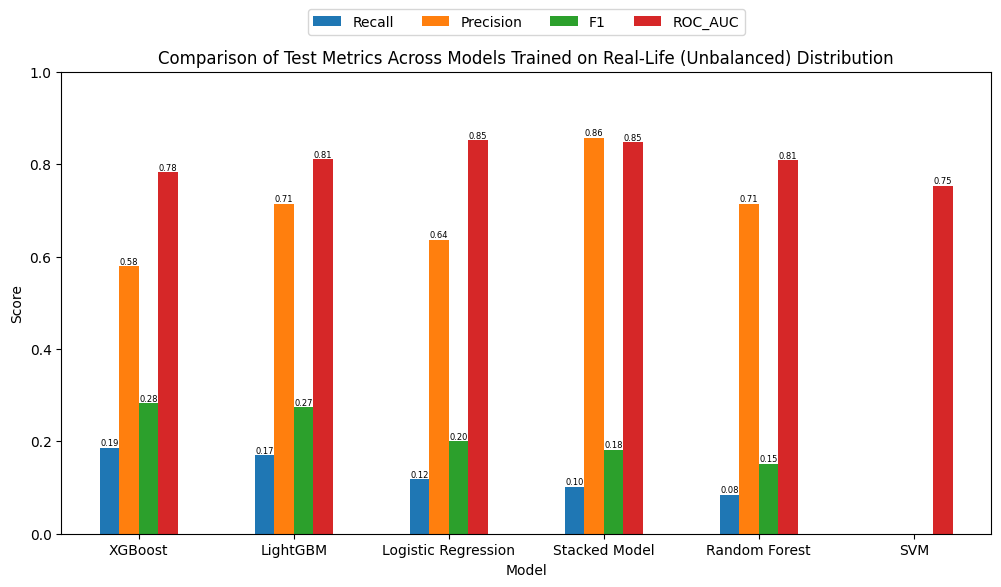

In [246]:
# Plot
metrics = ['Recall', 'Precision', 'F1', "ROC_AUC"]
df_plot = all_results_sorted.set_index('Model')[metrics]

ax = df_plot.plot(kind='bar', figsize=(12,6))
plt.title("Comparison of Test Metrics Across Models Trained on Real-Life (Unbalanced) Distribution")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)

# Add value labels on top of each bar, skipping 0
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0:   # skip 0 values
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=6, rotation=0)
# Move legend above the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(metrics))
plt.show()

In [247]:
# Classification report of best performing model (XGBoost)

# Predict on the test set (unscaled data for XGBoost)
# y_pred_xgb = xgb_model.predict(X_test_unscaled)

# Generate classification report
# xgb_report = classification_report(y_test, y_pred_xgb, digits=4)
print("=== XGBoost Classification Report ===")
# print(xgb_report)

# Generate report dictionary for XGBoost
xgb_report_dict = classification_report(
    y_test,
    y_pred_xgb,
    digits=4,
    output_dict=True)

# Convert to DataFrame
xgb_report_df = pd.DataFrame(xgb_report_dict).transpose()

# Optional: round to 4 decimals
xgb_report_df = xgb_report_df.round(4)

# Display
xgb_report_df

=== XGBoost Classification Report ===


,precision,recall,f1-score,support
0,0.9010,0.9820,0.9398,445.0000
1,0.5789,0.1864,0.2821,59.0000
accuracy,0.8889,0.8889,0.8889,0.8889
macro avg,0.7400,0.5842,0.6109,504.0000
weighted avg,0.8633,0.8889,0.8628,504.0000


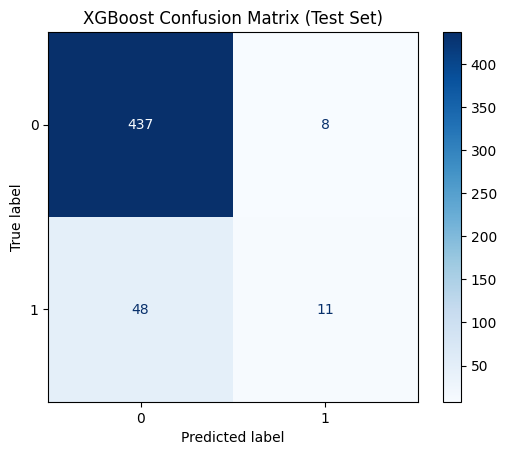

In [248]:
# Confusion matrix of best performing model (XGBoost)
# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_unscaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')  # values_format='d' shows integers
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.show()

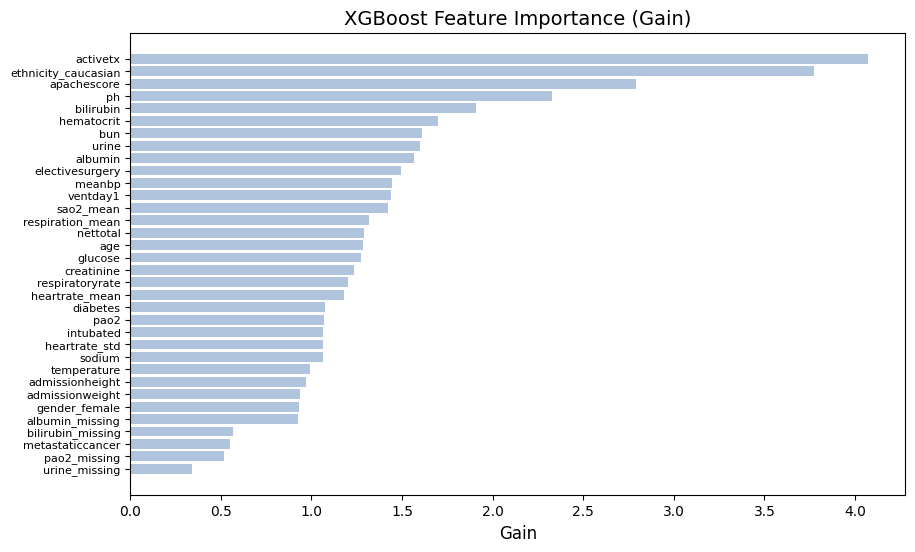

In [249]:
# Feature importance of best performing model (XGBoost)
# Get feature importances
importance = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())})

# Sort by importance descending
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
# plt.figure(figsize=(10,6))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='darkblue')
# plt.gca().invert_yaxis()  # highest importance at top
# plt.xlabel("Gain")
# plt.title("XGBoost Feature Importance (Gain)")
# plt.show()

plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightsteelblue')
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Gain", fontsize=12)   # x-axis label font size
plt.ylabel("")                    # optional: hide y-axis label
plt.title("XGBoost Feature Importance (Gain)", fontsize=14)
plt.tick_params(axis='y', labelsize=8)  # y-axis tick labels font size (feature names)
plt.tick_params(axis='x', labelsize=10) # x-axis tick labels font size
plt.show()

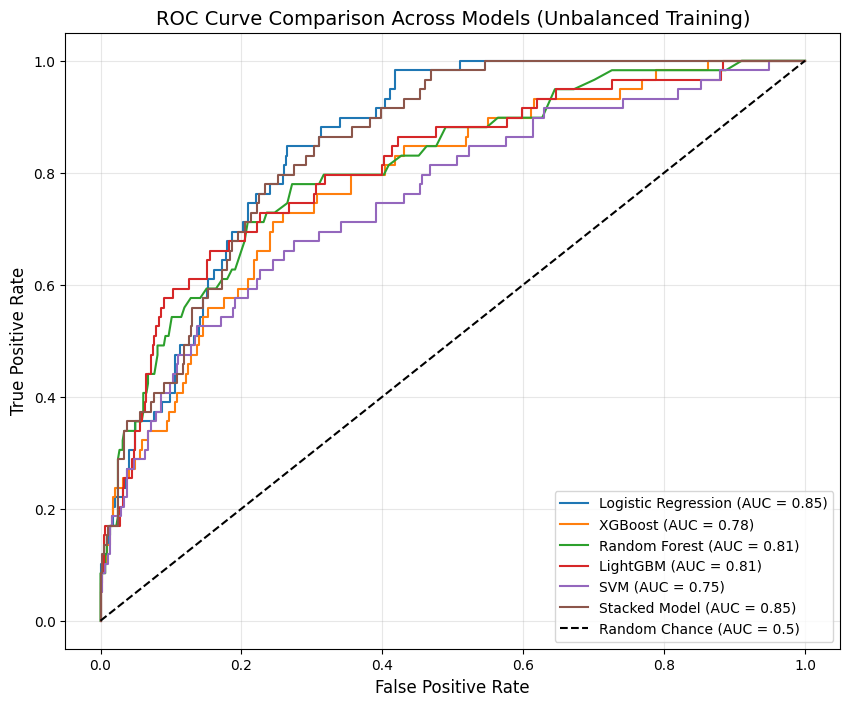

In [250]:
# ROC-AUC curve comparisons
# Dictionary of models and their predicted probabilities
model_probs = {
    "Logistic Regression": y_prob_log,   # from predict_proba[:,1]
    "XGBoost": y_prob_xgb,
    "Random Forest": y_prob_rf,
    "LightGBM": y_prob_lgb,
    "SVM": y_prob_svm,
    "Stacked Model": y_prob_stacked}

plt.figure(figsize=(10,8))

# Plot ROC curve for each model
for name, y_prob_model in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob_model)
    auc = roc_auc_score(y_test, y_prob_model)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot random chance line
plt.plot([0,1], [0,1], 'k--', label="Random Chance (AUC = 0.5)")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison Across Models (Unbalanced Training)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

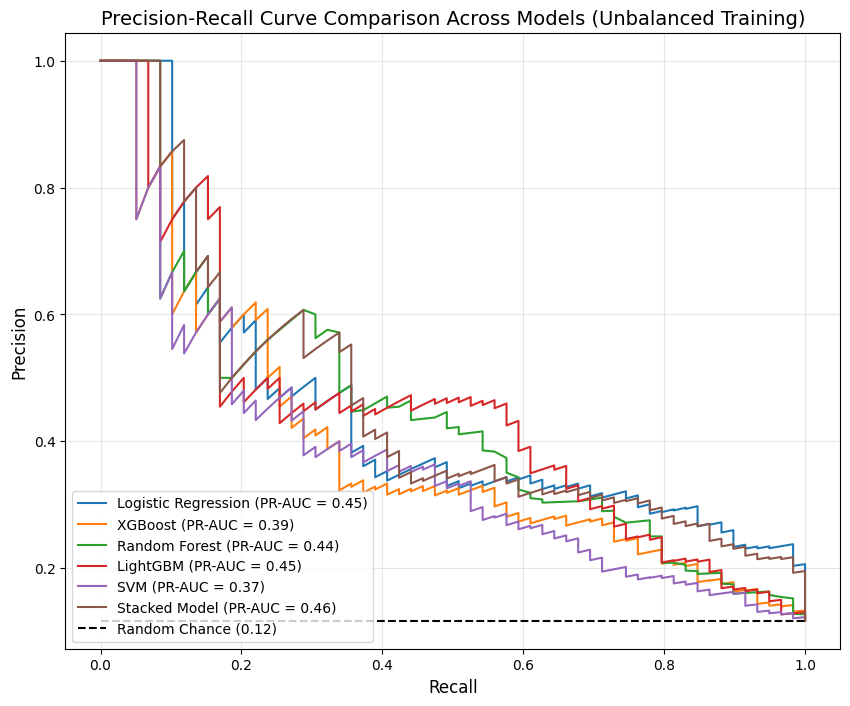

In [251]:
# PR-AUC curve comparisons
# Dictionary of models and their predicted probabilities
model_probs = {
    "Logistic Regression": y_prob_log,
    "XGBoost": y_prob_xgb,
    "Random Forest": y_prob_rf,
    "LightGBM": y_prob_lgb,
    "SVM": y_prob_svm,
    "Stacked Model": y_prob_stacked}

plt.figure(figsize=(10,8))

# Plot PR curve for each model
for name, y_prob_model in model_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob_model)
    pr_auc = average_precision_score(y_test, y_prob_model)
    plt.plot(recall, precision, label=f"{name} (PR-AUC = {pr_auc:.2f})")

# Plot baseline (random chance)
positive_ratio = y_test.mean()  # proportion of positive samples
plt.hlines(positive_ratio, 0, 1, colors='k', linestyles='--', label=f'Random Chance ({positive_ratio:.2f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve Comparison Across Models (Unbalanced Training)", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

**Balanced models**

Best performing model is our stacked model

In [252]:
# Table
# Combine all balanced results
all_results_bal = pd.DataFrame([
    logreg_results_bal,
    xgb_results_bal,
    rf_results_bal,
    lgb_results_bal,
    svm_results_bal,
    stack_results_bal])

# Sort by Recall first (important in ICU prediction), then F1
all_results_bal_sorted = all_results_bal.sort_values(by=['Recall', 'F1'], ascending=False)

# Reset index for a clean table
all_results_bal_sorted.reset_index(drop=True, inplace=True)

# Display
all_results_bal_sorted

,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,Stacked Model,0.779661,0.323944,0.457711,0.847305,0.435902
1,Logistic Regression,0.762712,0.294118,0.424528,0.842316,0.422831
2,SVM,0.440678,0.282609,0.344371,0.786060,0.282713
3,LightGBM,0.254237,0.483871,0.333333,0.806703,0.445674
4,XGBoost,0.203390,0.480000,0.285714,0.794934,0.386345
5,Random Forest,0.033898,0.666667,0.064516,0.816302,0.383567


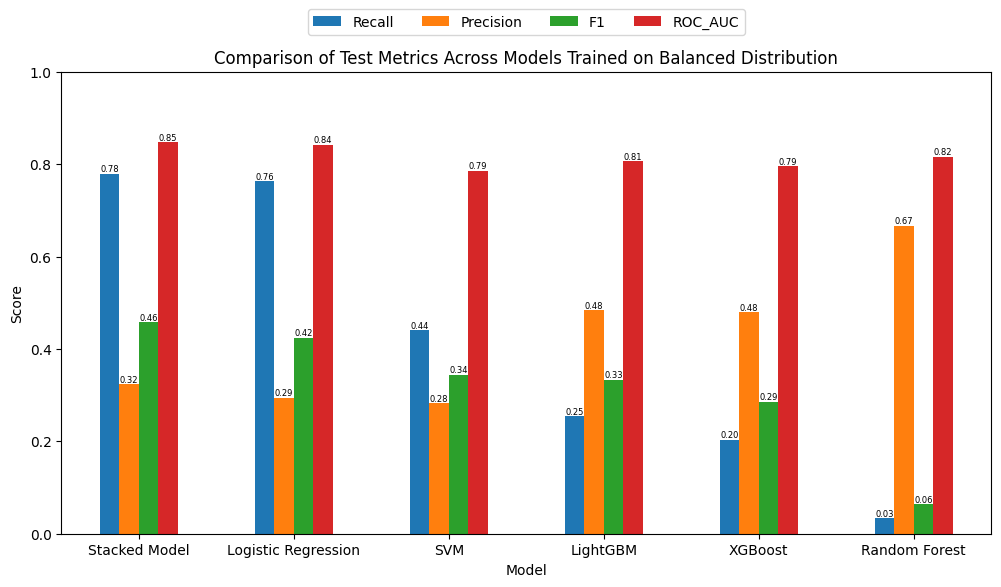

In [253]:
# Plot
# Metrics to plot
metrics = ['Recall', 'Precision', 'F1', "ROC_AUC"]
df_plot = all_results_bal_sorted.set_index('Model')[metrics]

# Bar plot
ax = df_plot.plot(kind='bar', figsize=(12,6))
plt.title("Comparison of Test Metrics Across Models Trained on Balanced Distribution")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=6, rotation=0)
# Move legend above the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(metrics))
plt.show()

In [254]:
# Classification report of best performing model (Stacked)
# Generate classification report
# stacked_report_bal = classification_report(y_test, y_pred_stacked_bal, digits=4)
print("=== Stacked Model (Balanced) Classification Report ===")
# print(stacked_report_bal)

# Generate report dictionary instead of string
report_dict = classification_report(
    y_test, 
    y_pred_stacked_bal, 
    digits=4, 
    output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Optional: round to 4 decimals for readability
report_df = report_df.round(4)

# Display
report_df

=== Stacked Model (Balanced) Classification Report ===


,precision,recall,f1-score,support
0,0.9641,0.7843,0.8649,445.0000
1,0.3239,0.7797,0.4577,59.0000
accuracy,0.7837,0.7837,0.7837,0.7837
macro avg,0.6440,0.7820,0.6613,504.0000
weighted avg,0.8892,0.7837,0.8173,504.0000


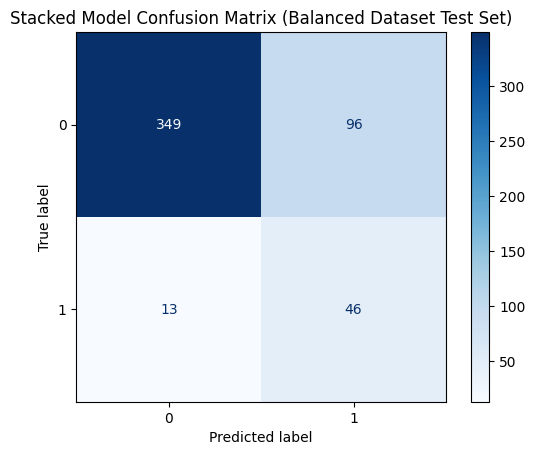

In [255]:
# Confusion matrix on best performing model (Stacked)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_stacked_bal)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')  # values_format='d' shows integers
plt.title("Stacked Model Confusion Matrix (Balanced Dataset Test Set)")
plt.show()

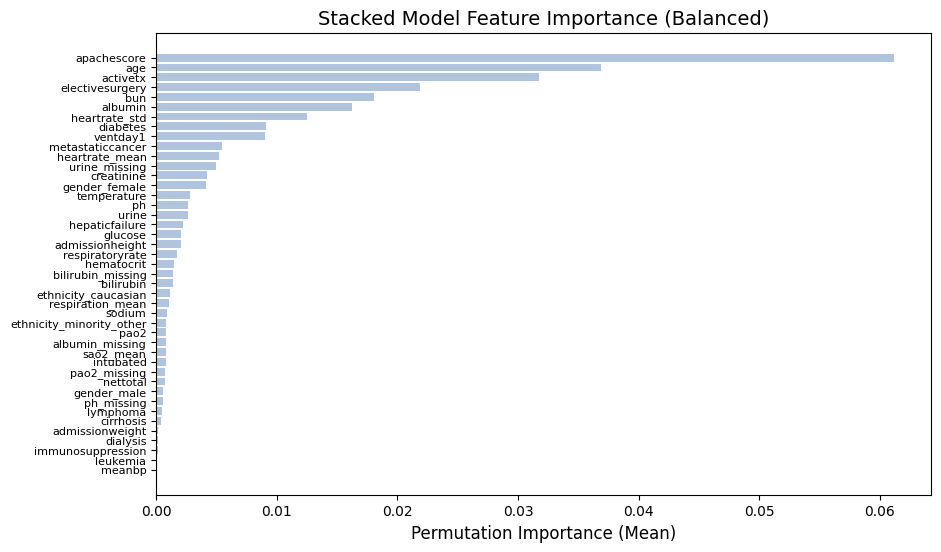

In [256]:
# Feature importance of best performing model (Stacked)
# Compute permutation importance
perm_importance = permutation_importance(
    stack_model_bal,       # fitted stacked model
    X_test_scaled,         # features
    y_test,                # target
    n_repeats=10,          # number of shuffles
    random_state=42,
    scoring='roc_auc') 

# Convert to DataFrame for plotting - this one shows negative and positive values
# importance_df = pd.DataFrame({
    # 'Feature': X_train_scaled.columns,
    # 'Importance': perm_importance.importances_mean})
# Absolute permutation importance for visualization
importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': np.abs(perm_importance.importances_mean)
}).sort_values(by='Importance', ascending=False)

# Sort by importance descending
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightsteelblue')
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Permutation Importance (Mean)", fontsize=12)
plt.ylabel("")
plt.title("Stacked Model Feature Importance (Balanced)", fontsize=14)
plt.tick_params(axis='y', labelsize=8)  # y-axis tick labels font size (feature names)
plt.tick_params(axis='x', labelsize=10) # x-axis tick labels font size
plt.show()

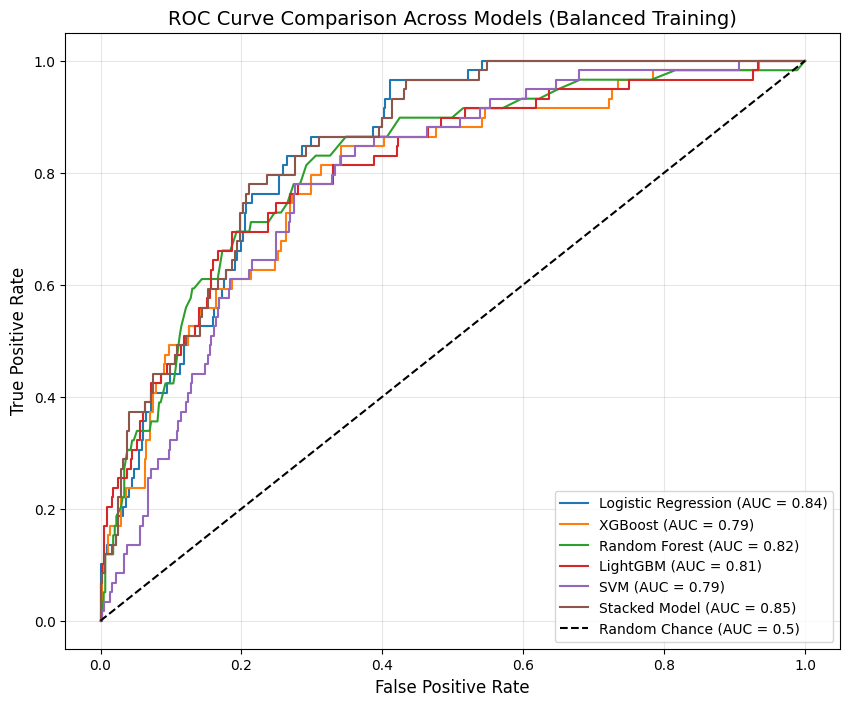

In [257]:
# ROC-AUC curve comparisons
# Dictionary of balanced models and their predicted probabilities
model_probs_bal = {
    "Logistic Regression": y_prob_log_bal,
    "XGBoost": y_prob_xgb_bal,
    "Random Forest": y_prob_rf_bal,
    "LightGBM": y_prob_lgb_bal,
    "SVM": y_prob_svm_bal,
    "Stacked Model": y_prob_stacked_bal}

plt.figure(figsize=(10,8))

# Plot ROC curve for each balanced model
for name, y_prob_model in model_probs_bal.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob_model)
    auc = roc_auc_score(y_test, y_prob_model)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot random chance line
plt.plot([0,1], [0,1], 'k--', label="Random Chance (AUC = 0.5)")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison Across Models (Balanced Training)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

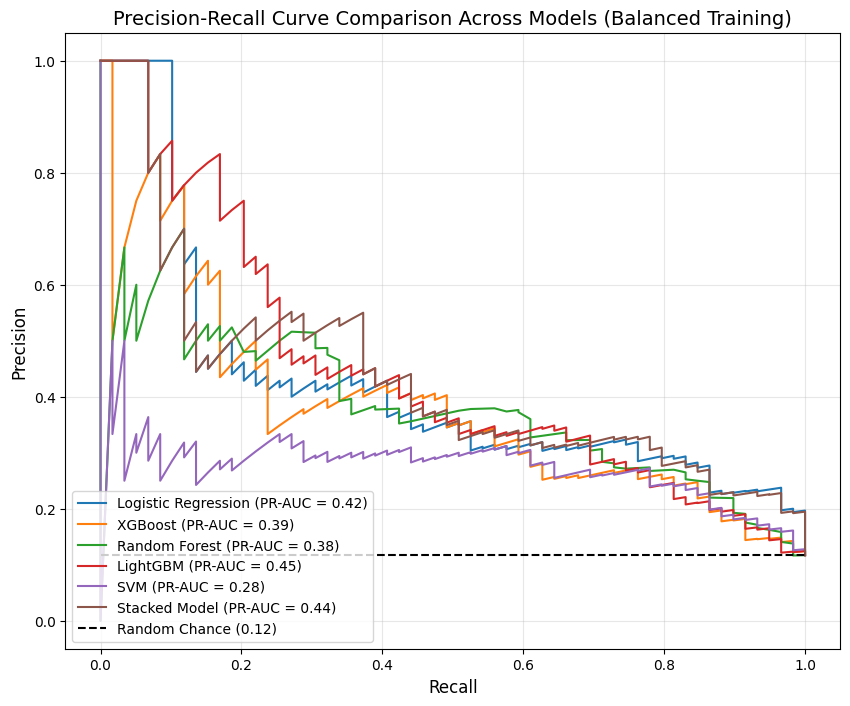

In [258]:
# PR-AUC curve comparisons
# Dictionary of balanced models and their predicted probabilities
model_probs_bal = {
    "Logistic Regression": y_prob_log_bal,
    "XGBoost": y_prob_xgb_bal,
    "Random Forest": y_prob_rf_bal,
    "LightGBM": y_prob_lgb_bal,
    "SVM": y_prob_svm_bal,
    "Stacked Model": y_prob_stacked_bal}

plt.figure(figsize=(10,8))

# Plot PR curve for each balanced model
for name, y_prob_model in model_probs_bal.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob_model)
    pr_auc = average_precision_score(y_test, y_prob_model)
    plt.plot(recall, precision, label=f"{name} (PR-AUC = {pr_auc:.2f})")

# Plot baseline (random chance)
positive_ratio = y_test.mean()  # proportion of positive samples
plt.hlines(positive_ratio, 0, 1, colors='k', linestyles='--', label=f'Random Chance ({positive_ratio:.2f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve Comparison Across Models (Balanced Training)", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

**Best model comparisons**

In [259]:
# Key metric comparison table
best_models_metrics = pd.DataFrame([
    {
        "Model": "XGBoost (Unbalanced)",
        "Recall": recall_score(y_test, y_pred_xgb),
        "Precision": precision_score(y_test, y_pred_xgb),
        "F1": f1_score(y_test, y_pred_xgb),
        "ROC_AUC": roc_auc_score(y_test, y_prob_xgb),
        "PR_AUC": average_precision_score(y_test, y_prob_xgb)},
    {
        "Model": "Stacked Model (Balanced)",
        "Recall": recall_score(y_test, y_pred_stacked_bal),
        "Precision": precision_score(y_test, y_pred_stacked_bal),
        "F1": f1_score(y_test, y_pred_stacked_bal),
        "ROC_AUC": roc_auc_score(y_test, y_prob_stacked_bal),
        "PR_AUC": average_precision_score(y_test, y_prob_stacked_bal)
    }])
display(best_models_metrics)

,Model,Recall,Precision,F1,ROC_AUC,PR_AUC
0,XGBoost (Unbalanced),0.186441,0.578947,0.282051,0.782784,0.393437
1,Stacked Model (Balanced),0.779661,0.323944,0.457711,0.847305,0.435902


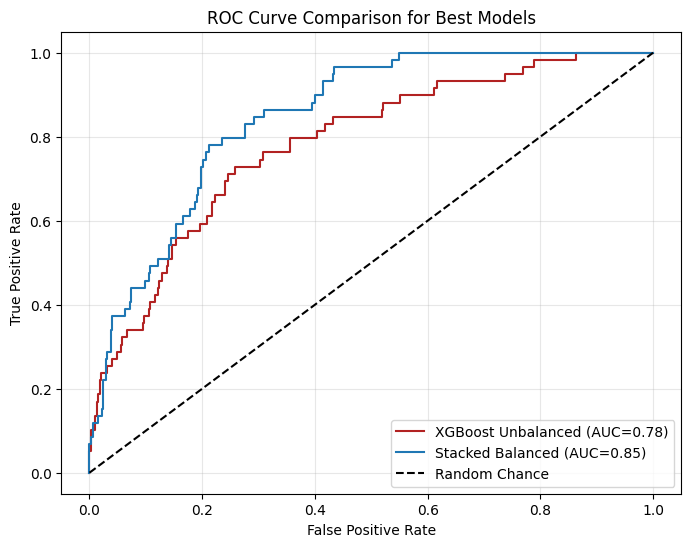

In [276]:
# ROC-AUC curve comparisons
plt.figure(figsize=(8,6))

# Plot XGBoost (Unbalanced) in red
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
auc = roc_auc_score(y_test, y_prob_xgb)
plt.plot(fpr, tpr, color="firebrick", label=f"XGBoost Unbalanced (AUC={auc:.2f})")

# Plot Stacked (Balanced) in blue
fpr, tpr, _ = roc_curve(y_test, y_prob_stacked_bal)
auc = roc_auc_score(y_test, y_prob_stacked_bal)
plt.plot(fpr, tpr, color='#1f77b4', label=f"Stacked Balanced (AUC={auc:.2f})")

# Random chance
plt.plot([0,1], [0,1], 'k--', label="Random Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Best Models")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

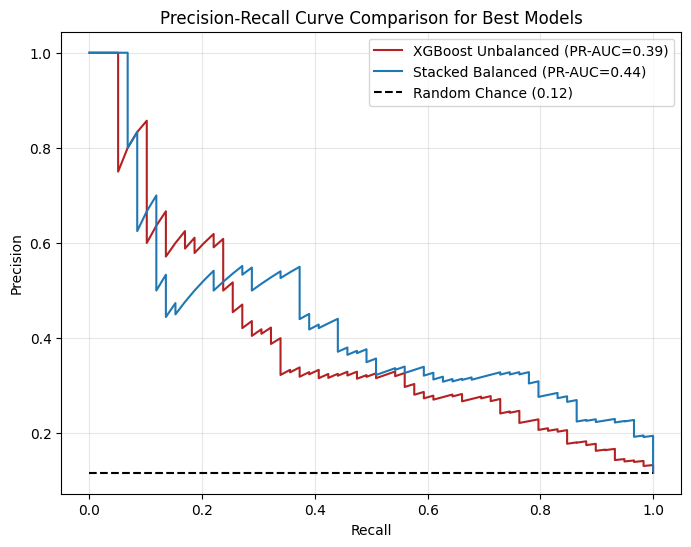

In [278]:
# PR-AUC curve comparison
plt.figure(figsize=(8,6))

# XGBoost Unbalanced (default blue)
precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc = average_precision_score(y_test, y_prob_xgb)
plt.plot(recall, precision, color="firebrick", label=f"XGBoost Unbalanced (PR-AUC={pr_auc:.2f})")

# Stacked Balanced (red)
precision, recall, _ = precision_recall_curve(y_test, y_prob_stacked_bal)
pr_auc = average_precision_score(y_test, y_prob_stacked_bal)
plt.plot(recall, precision, color='#1f77b4', label=f"Stacked Balanced (PR-AUC={pr_auc:.2f})")

# Random chance line
plt.hlines(y_test.mean(), 0, 1, colors='k', linestyles='--', label=f'Random Chance ({y_test.mean():.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison for Best Models")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

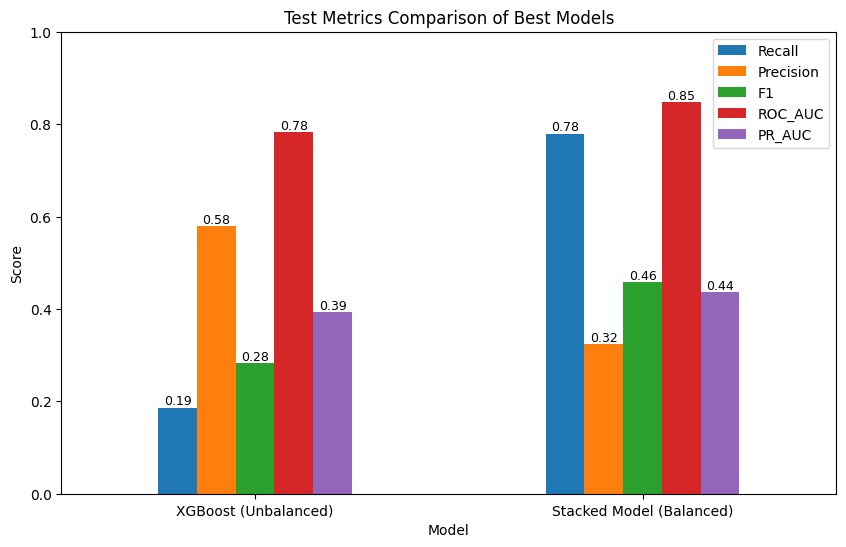

In [262]:
# Bar plot of metrics comparison
metrics = ['Recall', 'Precision', 'F1', 'ROC_AUC', 'PR_AUC']
df_plot = best_models_metrics.set_index('Model')[metrics]
ax = df_plot.plot(kind='bar', figsize=(10,6))
plt.ylim(0,1)
plt.title("Test Metrics Comparison of Best Models")
plt.ylabel("Score")
plt.xticks(rotation=0)

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)
plt.show()

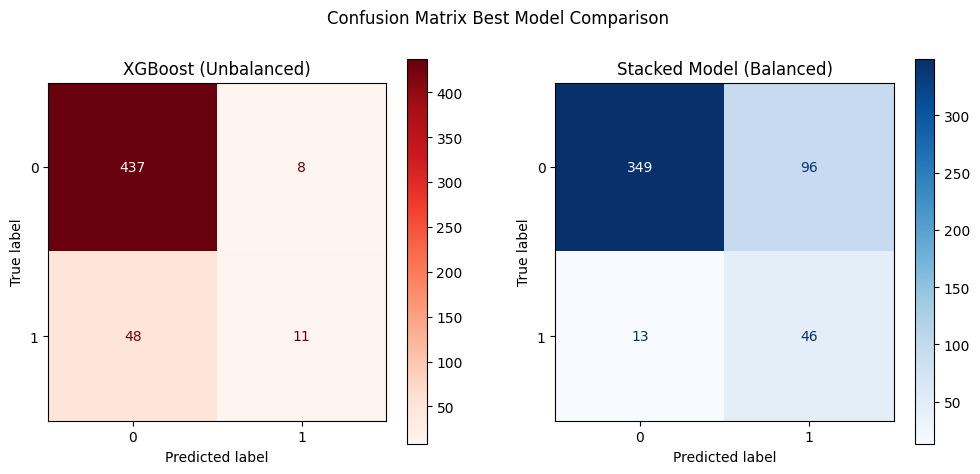

In [279]:
# Confusion matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0,1])
disp_xgb.plot(ax=axes[0], cmap='Reds', values_format='d')
axes[0].set_title("XGBoost (Unbalanced)")

# Stacked Model
cm_stack = confusion_matrix(y_test, y_pred_stacked_bal)
disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=[0,1])
disp_stack.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title("Stacked Model (Balanced)")

plt.suptitle("Confusion Matrix Best Model Comparison")
plt.show()

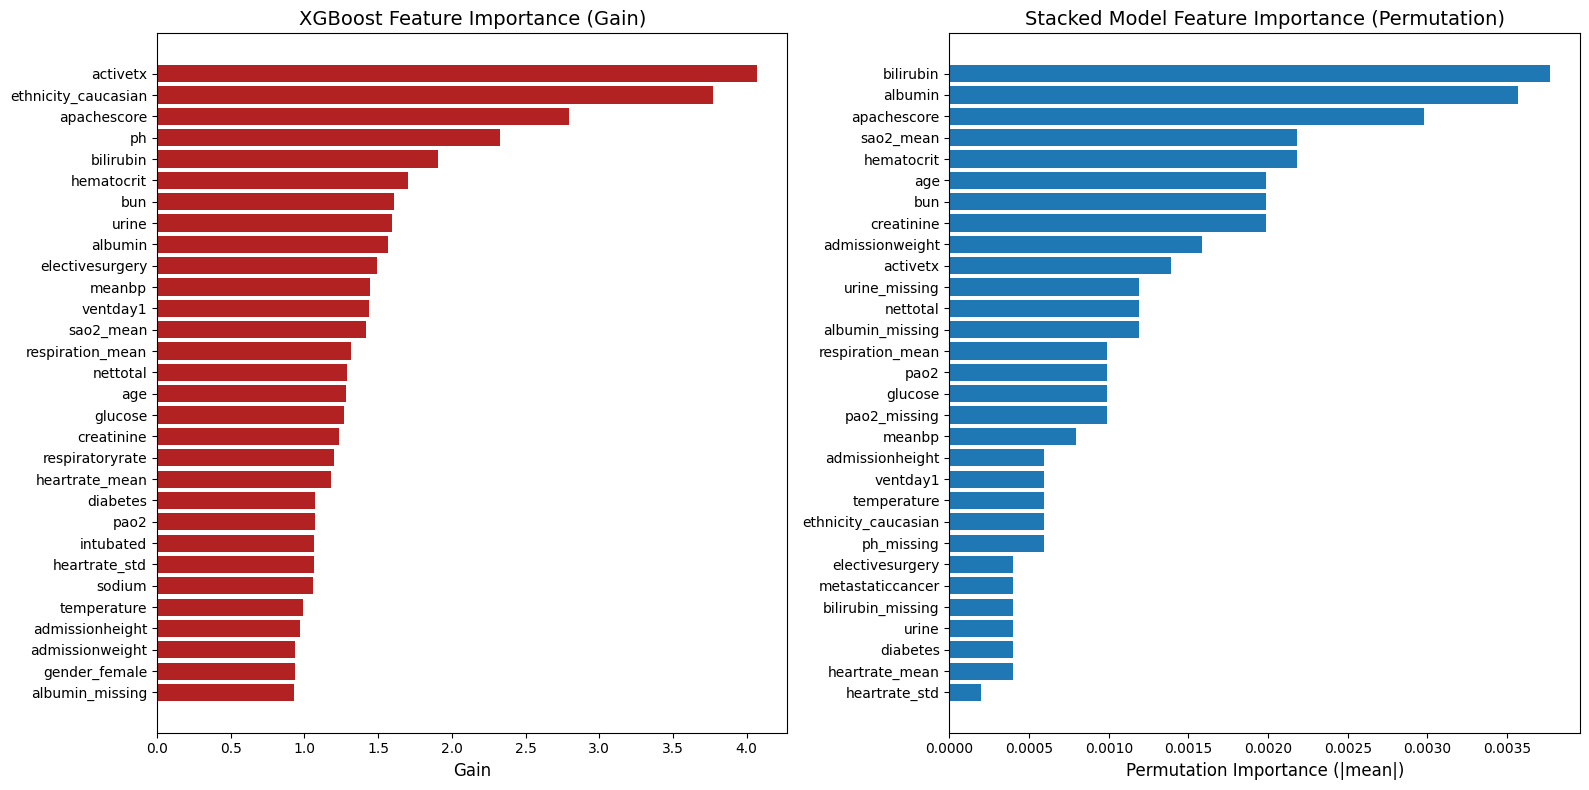

In [280]:
# Feature importance comparison
# XGBoost importance (Gain)
xgb_importance = xgb_model.get_booster().get_score(importance_type='gain')
xgb_df = pd.DataFrame({
    'Feature': list(xgb_importance.keys()),
    'Importance': list(xgb_importance.values())
}).sort_values(by='Importance', ascending=False)

# Stacked Model importance (Permutation Importance)
from sklearn.inspection import permutation_importance
stack_perm = permutation_importance(
    stack_model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

stack_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': np.abs(stack_perm.importances_mean)  # take absolute values
}).sort_values(by='Importance', ascending=False)

# Onlyy top features for clarity
top_n = 30
xgb_df_top = xgb_df.head(top_n)
stack_df_top = stack_df.head(top_n)

# Plot side by side
fig, axes = plt.subplots(1,2, figsize=(16,8))
# XGBoost
axes[0].barh(xgb_df_top['Feature'], xgb_df_top['Importance'], color='firebrick')
axes[0].invert_yaxis()
axes[0].set_title("XGBoost Feature Importance (Gain)", fontsize=14)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].set_xlabel("Gain", fontsize=12)
# Stacked Model
axes[1].barh(stack_df_top['Feature'], stack_df_top['Importance'], color='#1f77b4')
axes[1].invert_yaxis()
axes[1].set_title("Stacked Model Feature Importance (Permutation)", fontsize=14)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].set_xlabel("Permutation Importance (|mean|)", fontsize=12)
plt.tight_layout()
plt.show()

## **Part 20: ICU Simulation**

**Using best unbalanced/real-life distribution training model: XGBoost**

In [285]:
# Make sure we have X_test_unscaled and y_test
# Combine X_test_unscaled and y_test into a DataFrame for easy sampling
test_df = X_test_unscaled.copy()
test_df = pd.DataFrame(test_df, columns=X_unscaled.columns)
test_df['Actual'] = y_test
test_df['PatientID'] = df_unscaled.loc[y_test.index, 'patientunitstayid'].values  # assuming patient IDs are aligned

# Separate class 0 and class 1
class0 = test_df[test_df['Actual'] == 0]
class1 = test_df[test_df['Actual'] == 1]

# Sample 5 from each class for even distribution
sample0 = class0.sample(n=5, random_state=42)
sample1 = class1.sample(n=5, random_state=42)

# Combine
sim_sample = pd.concat([sample0, sample1])

# Predict with XGBoost
sim_sample['Predicted'] = xgb_model.predict(sim_sample[X_unscaled.columns])

# Check correctness
sim_sample['Correct?'] = np.where(sim_sample['Predicted'] == sim_sample['Actual'], 'Yes', 'No')

# Select and order columns
sim_table = sim_sample[['PatientID', 'Predicted', 'Actual', 'Correct?']]

# Reset index for neat table
sim_table.reset_index(drop=True, inplace=True)
sim_table

,PatientID,Predicted,Actual,Correct?
0,976535,0,0,Yes
1,3133874,0,0,Yes
2,674731,0,0,Yes
3,219980,0,0,Yes
4,2729266,0,0,Yes
5,2056365,0,1,No
6,1856821,0,1,No
7,1090567,0,1,No
8,2860660,0,1,No
9,3233306,1,1,Yes


**Using best balanced distribution training model: Stacked model**

In [286]:
# Combine X_test_scaled and y_test into a DataFrame for sampling
test_df_bal = X_test_scaled.copy()
test_df_bal = pd.DataFrame(test_df_bal, columns=X_scaled.columns)
test_df_bal['Actual'] = y_test
test_df_bal['PatientID'] = df_unscaled.loc[y_test.index, 'patientunitstayid'].values  # assuming patient IDs align

# Separate class 0 and class 1
class0 = test_df_bal[test_df_bal['Actual'] == 0]
class1 = test_df_bal[test_df_bal['Actual'] == 1]

# Sample 5 from each class for even distribution
sample0 = class0.sample(n=5, random_state=42)
sample1 = class1.sample(n=5, random_state=42)

# Combine
sim_sample_bal = pd.concat([sample0, sample1])

# Predict with Stacked model
sim_sample_bal['Predicted'] = stack_model_bal.predict(sim_sample_bal[X_scaled.columns])

# Check correctness
sim_sample_bal['Correct?'] = np.where(sim_sample_bal['Predicted'] == sim_sample_bal['Actual'], 'Yes', 'No')

# Optional: also add predicted probability
sim_sample_bal['Pred_Prob'] = stack_model_bal.predict_proba(sim_sample_bal[X_scaled.columns])[:,1]

# Select and order columns
sim_table_bal = sim_sample_bal[['PatientID', 'Predicted', 'Actual', 'Correct?']]

# Reset index for neat table
sim_table_bal.reset_index(drop=True, inplace=True)
sim_table_bal

,PatientID,Predicted,Actual,Correct?
0,976535,0,0,Yes
1,3133874,0,0,Yes
2,674731,0,0,Yes
3,219980,0,0,Yes
4,2729266,0,0,Yes
5,2056365,1,1,Yes
6,1856821,1,1,Yes
7,1090567,1,1,Yes
8,2860660,0,1,No
9,3233306,1,1,Yes


## **Part 21: Implications and Insights**

- See if threshold fine-tuning is appropriate for this objective research question. Because both models are performing similarily when applied threshold optimization tailored to recall. And the goal was to see if real life ICU distribution would be good or different than a balanced model. 
    - **Verdict:** Keep it at 0.5 because forcing it to be a high recall would be a post hoc analysis

- For future work
    - Multiple iteration, fine-tuning and threshold optimization, try making the stacked model better

- XGBoost tree-based nonlinear handles class imbalance extremely well